# Simplifying the Health Insurance Metal Level

## Classification Task 1: Binary Metal Level Classification ('Family Option' Plans)

## Classification Task 2: Multi-class Metal Level Classification ('Individual' Plans)

Metal Levels (Bronze, Silver, Gold, Platinum) were designed to simplify the plan selection process for customers. By building supervised classification models, we wish to better understand Metal Levels and simplify the method by which Metal Levels are determined. Today, Metal Levels are generated via an Excel Spreadsheet. This method is time consuming and requires domain-based knowledge to fill out.

### General Results

Dental Plans:     99% Accuracy given 2 Plan-Level attributes  
Small Business:   95% Accuracy given 5 Plan-Level attributes  
Individual Plans: 90% Accuracy given 11 Plan-Level attributes  

In [1]:
# Import libraries needed for processing and visualizations
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Acquisition and Preparation

## Attribute Selection from PlanAttributes.csv

In [2]:
df = pd.read_csv('PlanAttributes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77353 entries, 0 to 77352
Columns: 176 entries, AVCalculatorOutputNumber to WellnessProgramOffered
dtypes: float64(7), int64(9), object(160)
memory usage: 103.9+ MB


As seen below, there are 176 attributes available per plan. Most are 'Object' type or Strings that may be converted to numerical values. There are also many null values in the dataset. A data dictionary is available and helps interpret each attribute. The approach here is to capture as many attributes as possible that may be useful in modeling. We will narrow down the list of attributes in later sections. 

In [4]:
#Data Summary by Column, Null v Not Null Counts
print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format('Data Type','   Null', 'Not Null', 'Not Null %','','Column Name'))
for column in df.columns:
    print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format(df[column].dtype,
                                                         df[column].isnull().sum(), 
                                                         df[column].notnull().sum(),
                                                         round(df[column].notnull().sum()/df[column].notnull().count(),3),
                                                         ' ',column))

Data Type    Null  Not Null Not Null %      Column Name
object       1666    11910    0.877      AVCalculatorOutputNumber
int64           0    13576      1.0      BeginPrimaryCareCostSharingAfterNumberOfVisits
int64           0    13576      1.0      BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays
int64           0    13576      1.0      BenefitPackageId
int64           0    13576      1.0      BusinessYear
object          0    13576      1.0      CSRVariationType
object          0    13576      1.0      ChildOnlyOffering
object      13538       38    0.003      ChildOnlyPlanId
object       8010     5566     0.41      CompositeRatingOffered
object      13402      174    0.013      DEHBCombInnOonFamilyMOOP
object      13576        0      0.0      DEHBCombInnOonFamilyPerGroupMOOP
object      13576        0      0.0      DEHBCombInnOonFamilyPerPersonMOOP
object      13402      174    0.013      DEHBCombInnOonIndividualMOOP
object       9446     4130    0.304      DEHBDedCombInnOo

From a total of 176 Attributes in the PlanAttributes.csv file, the list of relevant attributes below was put together after referencing the PlansAttributes_DataDictionary.pdf, which describes each attribute's contents and meaning. Attributes that are not included are those containing Product ID's, URLs, redundant columns, import data, and free-text entries.

In [5]:
relevant = ['AVCalculatorOutputNumber','BeginPrimaryCareCostSharingAfterNumberOfVisits',
              'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays','BusinessYear',
              'ChildOnlyOffering','CompositeRatingOffered','DentalOnlyPlan',
              'EHBPediatricDentalApportionmentQuantity',
              'EHBPercentPremiumS4','EHBPercentTotalPremium','FirstTierUtilization',
              'HSAOrHRAEmployerContribution','HSAOrHRAEmployerContributionAmount',
              'InpatientCopaymentMaximumDays','IsGuaranteedRate','IsHSAEligible',
              'IsNewPlan','IsNoticeRequiredForPregnancy','IsReferralRequiredForSpecialist',
              'IssuerActuarialValue','MarketCoverage','MedicalDrugDeductiblesIntegrated',
              'MedicalDrugMaximumOutofPocketIntegrated',
              'MetalLevel','MultipleInNetworkTiers','NationalNetwork',
              'OutOfCountryCoverage','OutOfServiceAreaCoverage',
              'PlanType','QHPNonQHPTypeId',
              'SecondTierUtilization','StandardComponentId',
              'UniquePlanDesign','WellnessProgramOffered']

Additionally, the lists below: coinsurance, individual, family, and summary of benefits (SBC), target attributes that can be grouped into these categories. Organizing into these lists enables us to clean data efficiently in a later step

In [6]:
coinsurance = []
print ('{0:10} {1:10}'.format('    Not Null %','    Column Name'))
for column in df.columns:
    if ('Coinsurance' in column and 'Begin' not in column):
        print ((df[column].notnull().sum()/df[column].notnull().count()), column)
        coinsurance.append(column)

    Not Null %     Column Name
0.454552150854 DEHBDedInnTier1Coinsurance
0.0260754272245 DEHBDedInnTier2Coinsurance
0.454552150854 MEHBDedInnTier1Coinsurance
0.0260754272245 MEHBDedInnTier2Coinsurance
0.586034177961 SBCHavingDiabetesCoinsurance
0.587433706541 SBCHavingaBabyCoinsurance
0.107837360047 SpecialtyDrugMaximumCoinsurance
0.479522687095 TEHBDedInnTier1Coinsurance
0.0936210960519 TEHBDedInnTier2Coinsurance


In [7]:
individual = []
print ('{0:10} {1:10}'.format('    Not Null %','    Column Name'))
for column in df.columns:
    if ('Individual' in column) and ((df[column].notnull().sum()/df[column].notnull().count()) > 0):
        print ((df[column].notnull().sum()/df[column].notnull().count()), column)
        individual.append(column)

    Not Null %     Column Name
0.0128167354154 DEHBCombInnOonIndividualMOOP
0.454552150854 DEHBDedCombInnOonIndividual
0.454552150854 DEHBDedInnTier1Individual
0.0260754272245 DEHBDedInnTier2Individual
0.454552150854 DEHBDedOutOfNetIndividual
0.0128167354154 DEHBInnTier1IndividualMOOP
0.0128167354154 DEHBOutOfNetIndividualMOOP
0.0787418974661 MEHBCombInnOonIndividualMOOP
0.520477312905 MEHBDedCombInnOonIndividual
0.520477312905 MEHBDedInnTier1Individual
0.0284325279906 MEHBDedInnTier2Individual
0.520477312905 MEHBDedOutOfNetIndividual
0.0787418974661 MEHBInnTier1IndividualMOOP
0.00235710076606 MEHBInnTier2IndividualMOOP
0.0787418974661 MEHBOutOfNetIndividualMOOP
0.921258102534 TEHBCombInnOonIndividualMOOP
0.479522687095 TEHBDedCombInnOonIndividual
0.479522687095 TEHBDedInnTier1Individual
0.0936210960519 TEHBDedInnTier2Individual
0.479522687095 TEHBDedOutOfNetIndividual
0.921258102534 TEHBInnTier1IndividualMOOP
0.119696523276 TEHBInnTier2IndividualMOOP
0.921258102534 TEHBOutOfNetIndivid

In [8]:
family = []
print ('{0:10} {1:10}'.format('    Not Null %','    Column Name'))
for column in df.columns:
    if ('Family' in column) and ((df[column].notnull().sum()/df[column].notnull().count()) > 0):
        print ((df[column].notnull().sum()/df[column].notnull().count()), column)
        family.append(column)

    Not Null %     Column Name
0.0128167354154 DEHBCombInnOonFamilyMOOP
0.304213317619 DEHBDedCombInnOonFamily
0.150338833235 DEHBDedCombInnOonFamilyPerGroup
0.150338833235 DEHBDedCombInnOonFamilyPerPerson
0.304213317619 DEHBDedInnTier1Family
0.150338833235 DEHBDedInnTier1FamilyPerGroup
0.150338833235 DEHBDedInnTier1FamilyPerPerson
0.0260754272245 DEHBDedInnTier2FamilyPerGroup
0.0260754272245 DEHBDedInnTier2FamilyPerPerson
0.304213317619 DEHBDedOutOfNetFamily
0.150338833235 DEHBDedOutOfNetFamilyPerGroup
0.150338833235 DEHBDedOutOfNetFamilyPerPerson
0.0128167354154 DEHBInnTier1FamilyMOOP
0.0128167354154 DEHBOutOfNetFamilyMOOP
0.0575279905716 MEHBCombInnOonFamilyMOOP
0.0212139068945 MEHBCombInnOonFamilyPerGroupMOOP
0.0212139068945 MEHBCombInnOonFamilyPerPersonMOOP
0.348924572775 MEHBDedCombInnOonFamily
0.17155274013 MEHBDedCombInnOonFamilyPerGroup
0.17155274013 MEHBDedCombInnOonFamilyPerPerson
0.348924572775 MEHBDedInnTier1Family
0.17155274013 MEHBDedInnTier1FamilyPerGroup
0.17155274013 

In [9]:
SBC = []
print ('{0:10} {1:10}'.format('    Not Null %','    Column Name'))
for column in df.columns:
    if 'SBC' in column and 'Coinsurance' not in column:
        print ((df[column].notnull().sum()/df[column].notnull().count()), column)
        SBC.append(column)

    Not Null %     Column Name
0.586918090748 SBCHavingDiabetesCopayment
0.58750736594 SBCHavingDiabetesDeductible
0.587360047142 SBCHavingDiabetesLimit
0.587654684738 SBCHavingaBabyCopayment
0.58750736594 SBCHavingaBabyDeductible
0.587360047142 SBCHavingaBabyLimit


### We combine the column/attribute lists above to define our new dataframe without unnecessary columns

In [10]:
df = df[relevant + coinsurance + individual + family + SBC]
df.shape

(13576, 134)

### We create the key below to uniquely identify each plan by year

In [11]:
df['key'] = df['BusinessYear'].astype(str) + df['StandardComponentId']

## Attribute Data Cleaning

From the Relevant Attributes List: Attributes in the revelant category are converted from text (object dtypes) to their respective int, float, or binary versions. For example, 64% is converted to 0.64, Yes or No, to 0 and 1. 

In [12]:
def pConvert(x): #function to convert percentage (%) entries to a value between 0 - 1.
    if float(x) < 1:
        x = float(x)
    elif float(x) == 1:
        x = float(x)
    else:
        x = float(x)/float(100)
    return x

df['AVCalculatorOutputNumber'] = df.AVCalculatorOutputNumber.str.replace('%','')
df['AVCalculatorOutputNumber'] = pd.to_numeric(df.AVCalculatorOutputNumber,errors='raise')
df['AVCalculatorOutputNumber'] = df.AVCalculatorOutputNumber.apply(pConvert)

df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult and Child-only',value=1)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult and Child-Only',value=1)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Adult-Only',value=0)
df['ChildOnlyOffering'] = df.ChildOnlyOffering.replace(to_replace='Allows Child-Only',value=1)

df['CompositeRatingOffered'] = df.CompositeRatingOffered.replace(to_replace='Yes',value=1)
df['CompositeRatingOffered'] = df.CompositeRatingOffered.replace(to_replace='No',value=0)

df['DentalOnlyPlan'] = df.DentalOnlyPlan.replace(to_replace='Yes',value=1)
df['DentalOnlyPlan'] = df.DentalOnlyPlan.replace(to_replace='No',value=0)

df['EHBPediatricDentalApportionmentQuantity'] = df['EHBPediatricDentalApportionmentQuantity'].replace('[\$,)]','', regex=True).astype(float)

df['FirstTierUtilization'] = df.FirstTierUtilization.str.replace('%','')
df['FirstTierUtilization'] = pd.to_numeric(df.FirstTierUtilization,errors='raise')
df['FirstTierUtilization'] = df.FirstTierUtilization.apply(pConvert)

df['SecondTierUtilization'] = df.SecondTierUtilization.str.replace('%','')
df['SecondTierUtilization'] = pd.to_numeric(df.SecondTierUtilization,errors='raise')
df['SecondTierUtilization'] = df.SecondTierUtilization.apply(pConvert)

df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='NO',value=0)
df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='No',value=0)
df['HSAOrHRAEmployerContribution'] = df.HSAOrHRAEmployerContribution.replace(to_replace='Yes',value=1)

df['HSAOrHRAEmployerContributionAmount'] = df['HSAOrHRAEmployerContributionAmount'].replace('[\$,)]','', regex=True).astype(float)

df['IsGuaranteedRate'] = df.IsGuaranteedRate.replace(to_replace='Estimated Rate',value=0)
df['IsGuaranteedRate'] = df.IsGuaranteedRate.replace(to_replace='Guaranteed Rate',value=1)

df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='NO',value=0)
df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='No',value=0)
df['IsHSAEligible'] = df.IsHSAEligible.replace(to_replace='Yes',value=1)

df['IsNewPlan'] = df.IsNewPlan.replace(to_replace='Existing',value=0)
df['IsNewPlan'] = df.IsNewPlan.replace(to_replace='New',value=1)

df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='NO',value=0)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='No',value=0)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='Yes',value=1)
df['IsNoticeRequiredForPregnancy'] = df.IsNoticeRequiredForPregnancy.replace(to_replace='yes',value=1)

df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='No',value=0)
df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='Yes',value=1)
df['IsReferralRequiredForSpecialist'] = df.IsReferralRequiredForSpecialist.replace(to_replace='yes',value=1)

df['IssuerActuarialValue'] = df.IssuerActuarialValue.str.replace('%','')
df['IssuerActuarialValue'] = pd.to_numeric(df.IssuerActuarialValue,errors='raise')
df['IssuerActuarialValue'] = df.IssuerActuarialValue.apply(pConvert)

df['MarketCoverage'] = df.MarketCoverage.replace(to_replace='Individual',value=0)
df['MarketCoverage'] = df.MarketCoverage.replace(to_replace='SHOP (Small Group)',value=1)

df['MedicalDrugDeductiblesIntegrated'] = df.MedicalDrugDeductiblesIntegrated.replace(to_replace='No', value = 0)
df['MedicalDrugDeductiblesIntegrated'] = df.MedicalDrugDeductiblesIntegrated.replace(to_replace='Yes', value = 1)

df['MedicalDrugMaximumOutofPocketIntegrated'] = df.MedicalDrugMaximumOutofPocketIntegrated.replace(to_replace='No', value = 0)
df['MedicalDrugMaximumOutofPocketIntegrated'] = df.MedicalDrugMaximumOutofPocketIntegrated.replace(to_replace='Yes', value = 1)

df['MultipleInNetworkTiers'] = df.MultipleInNetworkTiers.replace(to_replace='No', value = 0)
df['MultipleInNetworkTiers'] = df.MultipleInNetworkTiers.replace(to_replace='Yes', value = 1)

df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='NO',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='no',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='No',value=0)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='YES',value=1)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='YEs',value=1)
df['NationalNetwork'] = df.NationalNetwork.replace(to_replace='Yes',value=1)

df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='No',value=0)
df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='YES',value=1)
df['OutOfCountryCoverage'] = df.OutOfCountryCoverage.replace(to_replace='Yes',value=1)

df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='No',value=0)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='YES',value=1)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='Yes',value=1)
df['OutOfServiceAreaCoverage'] = df.OutOfServiceAreaCoverage.replace(to_replace='yes',value=1)

df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='No',value=0)
df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='no',value=0)
df['UniquePlanDesign'] = df.UniquePlanDesign.replace(to_replace='Yes',value=1)

df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='yes',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Yes',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='no',value=0)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='No',value=0)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Guaranteed Rate',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Estimated Rate',value=1)
df['WellnessProgramOffered'] = df.WellnessProgramOffered.replace(to_replace='Allows Adult and Child-Only',value=1)

Cleaning Specific Attribute Categories - as mentioned earlier, each category is now cleaned. Like in the relevant list, entries are converted to their respective numerical values

In [13]:
for col in coinsurance:
    if 'Tier' in col:
        df[col] = df[col].replace(to_replace='$0', value = '0')
        df[col] = df[col].replace(to_replace='$0 ', value = '0')
        df[col] = df[col].str.replace('%','')
        df[col] = pd.to_numeric(df[col],errors='raise')
        df[col] = df[col].apply(pConvert)
    else:
        df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
        df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [14]:
for col in individual:
    df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [15]:
for col in family:
    df[col] = df[col].str.replace(' per group','')
    df[col] = df[col].str.replace(' per person','')
    df[col] = df[col].replace(to_replace='per group not applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per group Not Applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per person not applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='per person Not Applicable', value = np.nan)
    df[col] = df[col].replace(to_replace='Not Applicable', value = np.nan)
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

In [16]:
for col in SBC:
    df[col] = df[col].replace('[\$,)]','', regex=True).astype(float)

Now we can see that most of the columns are no longer 'Object' type and are now int or float type. 

In [17]:
#Data Summary by Column, Null v Not Null Counts
print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format('Data Type','   Null', 'Not Null', 'Not Null %','','Column Name'))
for column in df.columns:
    print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format(df[column].dtype,
                                                         df[column].isnull().sum(), 
                                                         df[column].notnull().sum(),
                                                         round(df[column].notnull().sum()/df[column].notnull().count(),3),
                                                         ' ',column))

Data Type    Null  Not Null Not Null %      Column Name
float64     13576        0      0.0      AVCalculatorOutputNumber
int64           0    13576      1.0      BeginPrimaryCareCostSharingAfterNumberOfVisits
int64           0    13576      1.0      BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays
int64           0    13576      1.0      BusinessYear
int64           0    13576      1.0      ChildOnlyOffering
float64      8010     5566     0.41      CompositeRatingOffered
int64           0    13576      1.0      DentalOnlyPlan
float64     12681      895    0.066      EHBPediatricDentalApportionmentQuantity
float64      6173     7403    0.545      EHBPercentPremiumS4
float64      8310     5266    0.388      EHBPercentTotalPremium
float64         0    13576      1.0      FirstTierUtilization
float64     11270     2306     0.17      HSAOrHRAEmployerContribution
float64     13528       48    0.004      HSAOrHRAEmployerContributionAmount
int64           0    13576      1.0      Inpa

We now save this dataframe as df_attr

In [19]:
df_attr = df
print ("Number of unique keys:",df_attr.key.unique().shape)
print ("Shape of df_attr:",df_attr.shape)

Number of unique keys: (3937,)
Shape of df_attr: (13576, 135)


# Prepare Plan-Level Rate data to Join with Plan Attributes

In [20]:
df = pd.read_csv('Rate.csv')

For the Rate.csv, the columns below are relevant for further analysis. Columns that are ignored include data import tags and redundant columns.

In [21]:
ordered_cols = ['BusinessYear','StateCode','IssuerId','PlanId','Tobacco','Age',
                'IndividualRate','IndividualTobaccoRate','PrimarySubscriberAndOneDependent',
                'PrimarySubscriberAndTwoDependents','PrimarySubscriberAndThreeOrMoreDependents',
                'Couple','CoupleAndOneDependent','CoupleAndTwoDependents',
                'CoupleAndThreeOrMoreDependents']

df_rate = df[ordered_cols]

df_rate['key'] = df_rate.BusinessYear.astype(str) + df_rate.PlanId

In [22]:
print ("Number of unique keys:",df_rate.key.unique().shape)
print ("Shape of rate data:",df_rate.shape)

Number of unique keys: (3938,)
Shape of rate data: (1872992, 16)


Here, we convert the age to a float value by designating some options to single numeric values. This enables us to use age as an attribute in our models, and since we are building separate models based on the 'Family Option', we can simply filter by Age == 66 or Age != 66.

In [23]:
df_rate['Age'] = df_rate.Age.str.replace('0-20','20')
df_rate['Age'] = df_rate.Age.str.replace('65 and over','65')
df_rate['Age'] = df_rate.Age.replace(to_replace="Family Option", value = '66')
df_rate['Age'] = df_rate.Age.astype(float)

df_rate['Tobacco'] = df_rate.Tobacco.replace(to_replace='No Preference', value = 0)
df_rate['Tobacco'] = df_rate.Tobacco.replace(to_replace='Tobacco User/Non-Tobacco User', value = 1)

In [24]:
df_rate.info() #Checking that our data is in proper data type form before we move forward

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872992 entries, 2095510 to 11439957
Data columns (total 16 columns):
BusinessYear                                 int64
StateCode                                    object
IssuerId                                     int64
PlanId                                       object
Tobacco                                      int64
Age                                          float64
IndividualRate                               float64
IndividualTobaccoRate                        float64
PrimarySubscriberAndOneDependent             float64
PrimarySubscriberAndTwoDependents            float64
PrimarySubscriberAndThreeOrMoreDependents    float64
Couple                                       float64
CoupleAndOneDependent                        float64
CoupleAndTwoDependents                       float64
CoupleAndThreeOrMoreDependents               float64
key                                          object
dtypes: float64(10), int64(3), object(3)


In [25]:
del df # Free some memory

## Join Rate and Attribute Tables

In [26]:
#Pre-join key check
print ("Plan Attribute keys:",df_attr.key.unique().shape)
print ("Rate keys:",df_rate.key.unique().shape)

Plan Attribute keys: (3937,)
Rate keys: (3938,)


In [27]:
df_join_RA = df_rate.merge(df_attr,how='left',on='key') #left, don't want to lose any rate keys
df_join_RA = df_join_RA.drop_duplicates()

In [28]:
# dropping and renaming redundant columns generated by the join operation
if 'BusinessYear_y' in df_join_RA.columns:
    df_join_RA = df_join_RA.drop('BusinessYear_y',axis=1)
    
df_join_RA = df_join_RA.rename(columns={'BusinessYear_x':'BusinessYear'})

In [29]:
#Post-join key check, appears that no keys were lost, which is good
print ('Joined Table key count:',df_join_RA.key.unique().shape)
print ('Joined Table Shape:',df_join_RA.shape)

Joined Table key count: (3938,)
Joined Table Shape: (1818921, 149)


In [30]:
df_join_RA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818921 entries, 0 to 4555884
Columns: 149 entries, BusinessYear to SBCHavingaBabyLimit
dtypes: float64(139), int64(3), object(7)
memory usage: 2.0+ GB


Saving df_join_RA for future use and to skip all steps above.

In [31]:
df_join_RA.to_csv('df_join_RA.csv',encoding='utf-8')

# Modeling Phase

We will now begin the modeling process using the joined dataset from the Rate & Plan Attributes files

In [32]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.grid_search import GridSearchCV

In [34]:
#define confusion matrix plotting function
labels = ['Catastrophic','Bronze','Silver','Gold','Platinum']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues,labels=labels):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 16)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize = 14)
    plt.yticks(tick_marks, labels, fontsize = 14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

In [35]:
#reload the joined table into the dataframe (only needed if the kernel is re-started)
df_join_RA = pd.read_csv('df_join_RA.csv')
df_join_RA = df_join_RA.iloc[:,1:]
df_join_RA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818921 entries, 0 to 1818920
Columns: 149 entries, BusinessYear to SBCHavingaBabyLimit
dtypes: float64(139), int64(3), object(7)
memory usage: 2.0+ GB


# Classification Task 1: Binary Classification

In [36]:
df = df_join_RA

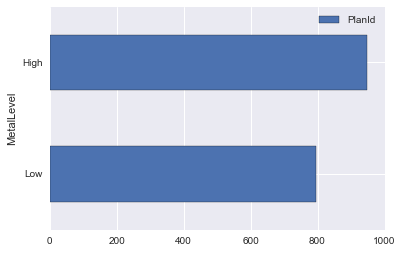

In [37]:
# Filter the data and verify only two levels exist for the Family Option criteria
# Age = 66 was designated to represent the Family Option
tmp = df[df['Age'] == 66].groupby('MetalLevel').count().reset_index().sort_values('PlanId', ascending = True)
tmp.plot(kind='barh',x ='MetalLevel', y='PlanId')

The family option contains two Metal Levels: Low and High. We will filter our original dataframe by 'Family Option' and inspect the remaining 'object' type attributes to generate one-hot encodings if needed. 

In [38]:
df = df[df['Age'] == 66]
df.shape

(1742, 149)

In [39]:
df.groupby('MetalLevel')['key','BusinessYear'].count() #verifying Metal Levels after filter

key  BusinessYear
MetalLevel                   
High        948           948
Low         794           794

In [40]:
df.groupby('PlanType')['key','BusinessYear'].count() #Plan Types to require one-hot encoding

key  BusinessYear
PlanType                    
HMO         15            15
PPO       1727          1727

In [41]:
#Qualified health plan designation to require one-hot encoding
df.groupby('QHPNonQHPTypeId')['key','BusinessYear'].count() 

key  BusinessYear
QHPNonQHPTypeId                     
Both               663           663
Off the Exchange  1079          1079

In [42]:
#Generate one-hot encodings
tmp_df = pd.get_dummies(df.PlanType,prefix='PlanType')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.QHPNonQHPTypeId,prefix='QHP')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [43]:
#Renaming a few columns for brevity
df = df.rename(columns = {'BeginPrimaryCareCostSharingAfterNumberOfVisits':'BeginCostSharingAfterNumberOfVisits'})
df = df.rename(columns = {'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays':'BeginDedCoinsAfterNumberOfCopays'})
df = df.rename(columns = {'EHBPediatricDentalApportionmentQuantity':'PediatricDentalApportionmentQty'})
df = df.rename(columns = {'InpatientCopaymentMaximumDays':'InpatientCopayMaxDays'})

As we can see below, very few of the Plan Attributes and Rates apply to the 'Family Option'. Given this, we will keep attributes that are 100% complete (contain no Null values) and will create another list of attributes to be imputed given that they at least have 50% of data available. The choice of 50% is a lower bound that the team felt was acceptable for imputing. Generally, we observed poor/biased distributions when we imputed attributes with less than 50% available data.

In [44]:
#Data Summary by Column, Null v Not Null Counts
print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format('Data Type','   Null', 'Not Null', 'Not Null %','','Column Name'))
for column in df.columns:
    print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format(df[column].dtype,
                                                         df[column].isnull().sum(), 
                                                         df[column].notnull().sum(),
                                                         round(df[column].notnull().sum()/df[column].notnull().count(),3),
                                                         ' ',column))

Data Type    Null  Not Null Not Null %      Column Name
int64           0     1742      1.0      BusinessYear
object          0     1742      1.0      StateCode
int64           0     1742      1.0      IssuerId
object          0     1742      1.0      PlanId  
int64           0     1742      1.0      Tobacco 
float64         0     1742      1.0      Age     
float64         0     1742      1.0      IndividualRate
float64      1742        0      0.0      IndividualTobaccoRate
float64         0     1742      1.0      PrimarySubscriberAndOneDependent
float64         0     1742      1.0      PrimarySubscriberAndTwoDependents
float64         0     1742      1.0      PrimarySubscriberAndThreeOrMoreDependents
float64         0     1742      1.0      Couple  
float64         0     1742      1.0      CoupleAndOneDependent
float64         0     1742      1.0      CoupleAndTwoDependents
float64         0     1742      1.0      CoupleAndThreeOrMoreDependents
object          0     1742      1.0    

List of Attributes with no missing values

In [45]:
#The items in the noNeed list are exceptions that will not be needed in the modeling portion but otherwise qualify
noNeed = ['IssuerId']
noNulls = []
for column in df.columns:
    if ((df[column].notnull().sum()/df[column].notnull().count() == 1) and (df[column].dtype != 'object')
       and (column not in noNeed)):
        print ('{0:6} {1:20}'.format(df[column].notnull().sum()/df[column].notnull().count(),column))
        noNulls.append(column)

   1.0 BusinessYear        
   1.0 Tobacco             
   1.0 Age                 
   1.0 IndividualRate      
   1.0 PrimarySubscriberAndOneDependent
   1.0 PrimarySubscriberAndTwoDependents
   1.0 PrimarySubscriberAndThreeOrMoreDependents
   1.0 Couple              
   1.0 CoupleAndOneDependent
   1.0 CoupleAndTwoDependents
   1.0 CoupleAndThreeOrMoreDependents
   1.0 BeginCostSharingAfterNumberOfVisits
   1.0 BeginDedCoinsAfterNumberOfCopays
   1.0 ChildOnlyOffering   
   1.0 DentalOnlyPlan      
   1.0 PediatricDentalApportionmentQty
   1.0 FirstTierUtilization
   1.0 InpatientCopayMaxDays
   1.0 IsGuaranteedRate    
   1.0 IsNewPlan           
   1.0 IssuerActuarialValue
   1.0 MarketCoverage      
   1.0 MultipleInNetworkTiers
   1.0 NationalNetwork     
   1.0 OutOfCountryCoverage
   1.0 OutOfServiceAreaCoverage
   1.0 PlanType_HMO        
   1.0 PlanType_PPO        
   1.0 QHP_Both            
   1.0 QHP_Off the Exchange


List of attributes that may be imputed as more than 50% of data is available. Imputed with medians. 

In [46]:
imputed = []
for column in df.columns:
    if ((column not in noNulls) and (df[column].dtype != 'object') and (column not in noNeed)
       and ( df[column].notnull().sum()/df[column].notnull().count() > 0.5 )):
        print ('{0:6} {1:20}'.format(round(df[column].notnull().sum()/df[column].notnull().count(),4),column))
        imputed.append(column)

0.5189 MEHBDedInnTier1Individual
0.7239 MEHBInnTier1IndividualMOOP
0.5545 MEHBInnTier1FamilyMOOP


In [47]:
df.MEHBDedInnTier1Individual = df.MEHBDedInnTier1Individual.fillna(df.MEHBDedInnTier1Individual.median()) #median
df.MEHBInnTier1IndividualMOOP = df.MEHBInnTier1IndividualMOOP.fillna(df.MEHBInnTier1IndividualMOOP.median()) #median
df.MEHBInnTier1FamilyMOOP = df.MEHBInnTier1FamilyMOOP.fillna(df.MEHBInnTier1FamilyMOOP.median()) #median

The colX list contains attribute names that will be used in the models

In [55]:
colX = noNulls + imputed

Before we model, we will separate our attributes into continuous and categorical feature types. The OneLevel list will capture attributes that only have 1 value and thus offer no value in the modeling process and will thus be excluded from colX

In [56]:
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)
        
colX = continuous + categorical

     3 Continuous   int64      BusinessYear        
     1 One Level    int64      Tobacco             
     1 One Level    float64    Age                 
  1150 Continuous   float64    IndividualRate      
  1484 Continuous   float64    PrimarySubscriberAndOneDependent
  1506 Continuous   float64    PrimarySubscriberAndTwoDependents
  1565 Continuous   float64    PrimarySubscriberAndThreeOrMoreDependents
  1243 Continuous   float64    Couple              
  1527 Continuous   float64    CoupleAndOneDependent
  1572 Continuous   float64    CoupleAndTwoDependents
  1576 Continuous   float64    CoupleAndThreeOrMoreDependents
     1 One Level    float64    BeginCostSharingAfterNumberOfVisits
     1 One Level    float64    BeginDedCoinsAfterNumberOfCopays
     1 One Level    float64    ChildOnlyOffering   
     1 One Level    float64    DentalOnlyPlan      
    89 Continuous   float64    PediatricDentalApportionmentQty
     1 One Level    float64    FirstTierUtilization
     1 One Level   

## Collinearity Analysis

We will now explore the correlations between attributes. 

(1742, 12)


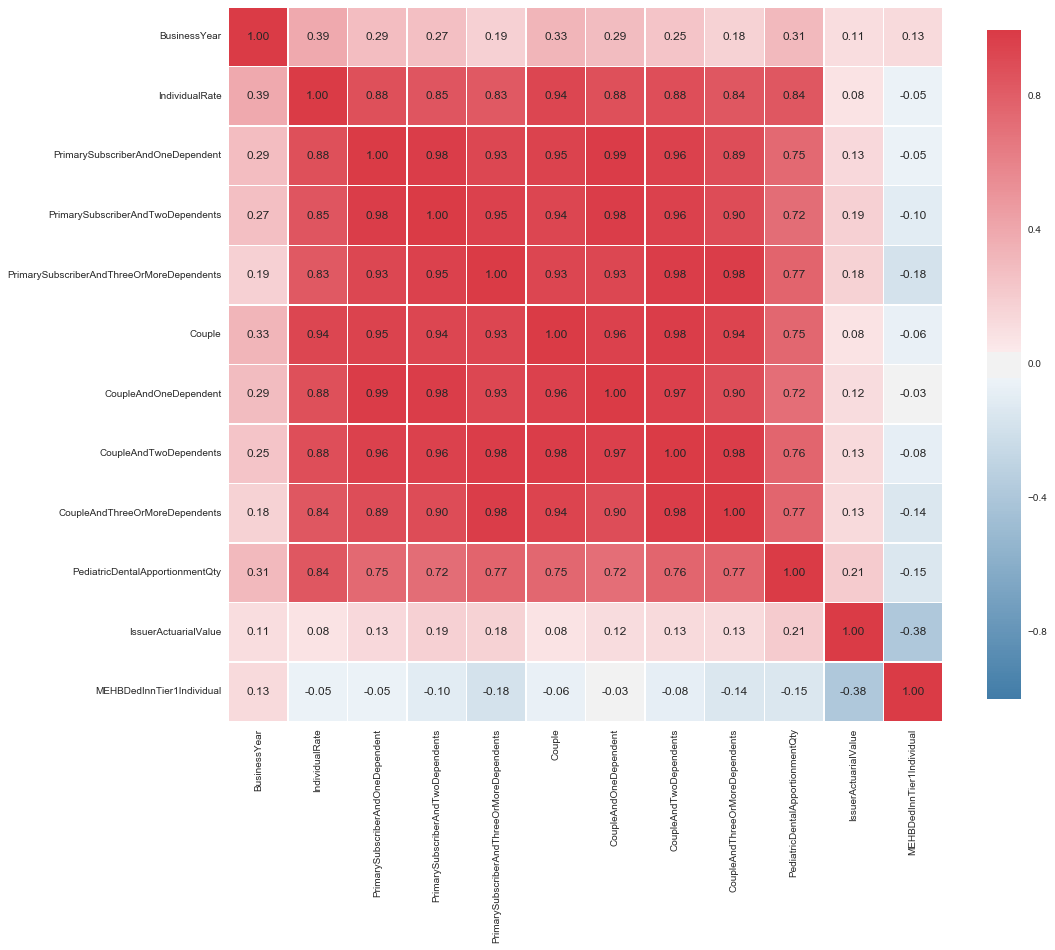

In [57]:
tmp = df[continuous]
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')

The above correlation matrix shows a large amount of collinearity among the variables.  We will create a temporary array for the attributes that we wish to keep in the model by removing attributes showed the highest collinearity.  We will then repeat the process of creating arrays for the continuous and categorical variables. 

In [58]:
collinear = ['PrimarySubscriberAndOneDependent','PrimarySubscriberAndTwoDependents',
            'CoupleAndOneDependent','CoupleAndTwoDependents']

tmp = []
for col in colX:
    if col not in collinear:
        tmp.append(col)
        
colX = tmp

In [59]:
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)

     3 Continuous   int64      BusinessYear        
  1150 Continuous   float64    IndividualRate      
  1565 Continuous   float64    PrimarySubscriberAndThreeOrMoreDependents
  1243 Continuous   float64    Couple              
  1576 Continuous   float64    CoupleAndThreeOrMoreDependents
    89 Continuous   float64    PediatricDentalApportionmentQty
    28 Continuous   float64    IssuerActuarialValue
     9 Continuous   float64    MEHBDedInnTier1Individual
     2 Categorical  float64    IsGuaranteedRate    
     2 Categorical  float64    IsNewPlan           
     2 Categorical  float64    MarketCoverage      
     2 Categorical  float64    NationalNetwork     
     2 Categorical  float64    OutOfCountryCoverage
     2 Categorical  float64    OutOfServiceAreaCoverage
     2 Categorical  float64    PlanType_HMO        
     2 Categorical  float64    PlanType_PPO        
     2 Categorical  float64    QHP_Both            
     2 Categorical  float64    QHP_Off the Exchange
     2 Catego

(1742, 8)


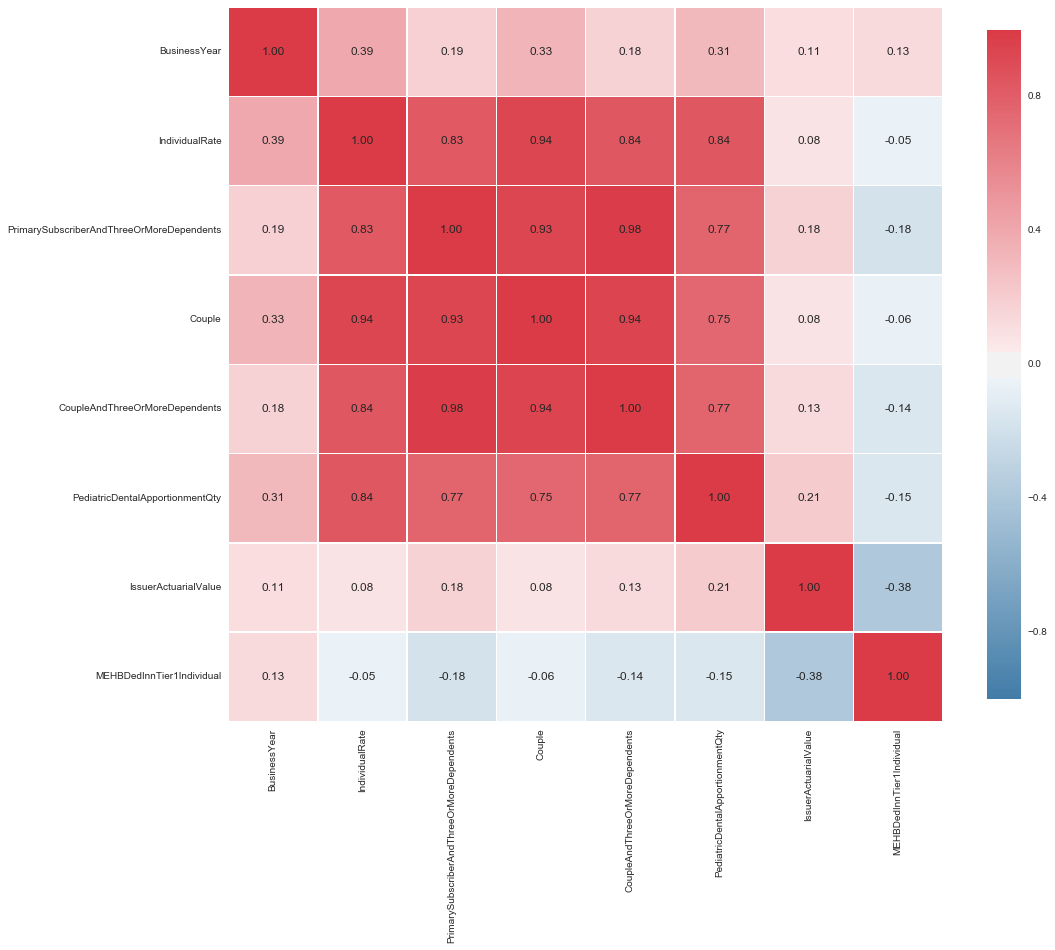

In [60]:
tmp = df[continuous]
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')

Based on the correlation matrix above, the correlation among variables has been reduced although it remains high between some of the continuous attributes. We decided to keep the attributes above as they may shed light on the Metal Level determination.   

The data will now be prepared for modeling.  We will begin with the multinomial naive bayes model.  We utilize a 70/30 shufflesplit to randomize our data between the training and test sets, along with 10 iterations for cross-validation of the model.  A seed value of 42 is set to maintain consistency when we compare models.  A Grid Search is utilized to test multiple parameter values for each model. 

By default, grid search scoring is based on accuracy unless otherwise specified. In this binary classification case, we believe that accuracy is an adequate comparison measure between models as there is no compelling argument to prioritize recall or precision over accuracy. 

In [62]:
colX = continuous + categorical #Final set of attributes before modeling

In [63]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]} #only viable parameter at this point

In [64]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
gs = GridSearchCV(mnb, parameters, cv=cv, n_jobs=-1, verbose=10)

gs.fit(df[colX], df['MetalLevel'])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.632887 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.623327 -   0.1s
[CV] ........................... alpha=0.0001, score=0.613767 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.611855 -   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.632887 -   0.1s
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.000

[Parallel(n_jobs=-1)]: Batch computation too fast (0.0797s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s


[CV] ........................... alpha=0.0001, score=0.600382 -   0.1s
[CV] ........................... alpha=0.0001, score=0.621415 -   0.0s
[CV] ........................... alpha=0.0001, score=0.632887 -   0.0s
[CV] alpha=0.0001 ....................................................
[CV] alpha=0.01 ......................................................
[CV] alpha=0.1 .......................................................
[CV] ............................. alpha=0.01, score=0.623327 -   0.0s
[CV] ........................... alpha=0.0001, score=0.615679 -   0.0s
[CV] ............................. alpha=0.01, score=0.621415 -   0.0s
[CV] alpha=0.01 ......................................................
[CV] alpha=0.01 ......................................................
[CV] .............................. alpha=0.1, score=0.613767 -   0.0s
[CV] alpha=0.01 ......................................................
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s


[CV] ............................... alpha=10, score=0.615679 -   0.0s
[CV] alpha=100 .......................................................
[CV] alpha=100 .......................................................
[CV] .............................. alpha=100, score=0.611855 -   0.0s
[CV] .............................. alpha=100, score=0.621415 -   0.0s
[CV] ............................... alpha=10, score=0.621415 -   0.0s
[CV] .............................. alpha=100, score=0.611855 -   0.0s
[CV] alpha=100 .......................................................
[CV] alpha=100 .......................................................
[CV] alpha=100 .......................................................
[CV] .............................. alpha=100, score=0.630975 -   0.0s
[CV] .............................. alpha=100, score=0.629063 -   0.0s
[CV] .............................. alpha=100, score=0.623327 -   0.0s
[CV] alpha=100 .......................................................
[CV] a

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


GridSearchCV(cv=ShuffleSplit(1742, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [65]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True) #sorted grid scores

[mean: 0.62065, std: 0.01009, params: {'alpha': 0.0001},
 mean: 0.62065, std: 0.01009, params: {'alpha': 0.01},
 mean: 0.62065, std: 0.01009, params: {'alpha': 0.1},
 mean: 0.62065, std: 0.01009, params: {'alpha': 1},
 mean: 0.62046, std: 0.01048, params: {'alpha': 10},
 mean: 0.61989, std: 0.01040, params: {'alpha': 100}]

In [66]:
print (gs.best_score_, gs.best_params_) #display best score and parameters

0.620650095602 {'alpha': 0.0001}


### Best MultinomialNB classifier achieved 62% accuracy

### We will not try BernoulliNB

In [67]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100],
              'binarize': [0, 0.1, 0.3, 0.5, 1]}

In [68]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
gs = GridSearchCV(bnb, parameters, cv=cv, n_jobs=-1, verbose=10)

gs.fit(df[colX], df['MetalLevel'])

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.0001 ........................................
[CV] ............... binarize=0, alpha=0.0001, score=0.634799 -   0.1s
[CV] ............... binarize=0, alpha=0.0001, score=0.646272 -   0.1s
[CV] binarize=0, alpha=0.0001 ........................................
[CV] ............... binarize=0, alpha=0.0001, score=0.657744 -   0.1s
[CV] ............... binarize=0, alpha=0.0001, score=0.642447 -   0.1s
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.0001 ........................................
[CV] ............... binarize=0, alpha=0.0001, score=0.644359 -   0.1s
[CV] .........

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1078s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] ............. binarize=0.1, alpha=0.0001, score=0.634799 -   0.0s
[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] ............... binarize=0, alpha=0.0001, score=0.667304 -   0.0s
[CV] ............. binarize=0.1, alpha=0.0001, score=0.657744 -   0.0s
[CV] ............. binarize=0.1, alpha=0.0001, score=0.644359 -   0.0s
[CV] binarize=0, alpha=0.0001 ........................................
[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] ............. binarize=0.1, alpha=0.0001, score=0.642447 -   0.1s
[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] binarize=0.1, alpha=0.0001 ......................................
[CV] ............. binarize=0.1, alpha=0.0001, score=0.646272 -   0.0s
[CV] ............. binarize=0.1, alpha=0.0001, score=0.625239 -   0.0s
[CV] .

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1971s.) Setting batch_size=4.


[CV] binarize=0.5, alpha=0.0001 ......................................
[CV] ............. binarize=0.5, alpha=0.0001, score=0.642447 -   0.0s
[CV] binarize=1, alpha=0.0001 ........................................
[CV] binarize=1, alpha=0.0001 ........................................
[CV] ............. binarize=0.5, alpha=0.0001, score=0.646272 -   0.0s
[CV] binarize=1, alpha=0.0001 ........................................
[CV] ............... binarize=1, alpha=0.0001, score=0.512428 -   0.0s
[CV] binarize=1, alpha=0.0001 ........................................
[CV] binarize=0, alpha=0.01 ..........................................
[CV] ............... binarize=1, alpha=0.0001, score=0.554493 -   0.0s
[CV] ............... binarize=1, alpha=0.0001, score=0.560229 -   0.0s
[CV] ............... binarize=1, alpha=0.0001, score=0.562141 -   0.0s
[CV] binarize=1, alpha=0.0001 ........................................
[CV] binarize=1, alpha=0.0001 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.7s


[CV] ................. binarize=0, alpha=0.01, score=0.667304 -   0.0s
[CV] binarize=0.1, alpha=0.01 ........................................
[CV] ............... binarize=0.1, alpha=0.01, score=0.657744 -   0.0s
[CV] binarize=0, alpha=0.01 ..........................................
[CV] binarize=0.1, alpha=0.01 ........................................
[CV] ............... binarize=0.3, alpha=0.01, score=0.634799 -   0.0s
[CV] ............... binarize=0.1, alpha=0.01, score=0.646272 -   0.0s
[CV] binarize=0.3, alpha=0.01 ........................................
[CV] ................. binarize=0, alpha=0.01, score=0.646272 -   0.0s
[CV] ............... binarize=0.1, alpha=0.01, score=0.642447 -   0.0s
[CV] ............... binarize=0.3, alpha=0.01, score=0.657744 -   0.0s
[CV] binarize=0.3, alpha=0.01 ........................................
[CV] binarize=0.3, alpha=0.01 ........................................
[CV] binarize=0.5, alpha=0.01 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.0s


[CV] binarize=0.1, alpha=0.1 .........................................
[CV] ................ binarize=0.1, alpha=0.1, score=0.667304 -   0.0s
[CV] binarize=0.1, alpha=0.1 .........................................
[CV] ................ binarize=0.1, alpha=0.1, score=0.644359 -   0.0s
[CV] binarize=0.1, alpha=0.1 .........................................
[CV] .................. binarize=0, alpha=0.1, score=0.642447 -   0.0s
[CV] ................ binarize=0.1, alpha=0.1, score=0.634799 -   0.0s
[CV] binarize=0.1, alpha=0.1 .........................................
[CV] ................ binarize=0.1, alpha=0.1, score=0.646272 -   0.0s
[CV] ................ binarize=0.1, alpha=0.1, score=0.625239 -   0.0s
[CV] binarize=0.3, alpha=0.1 .........................................
[CV] ................ binarize=0.1, alpha=0.1, score=0.657744 -   0.0s
[CV] binarize=0.3, alpha=0.1 .........................................
[CV] binarize=0.3, alpha=0.1 .........................................
[CV] b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.3s


[CV] binarize=1, alpha=0.1 ...........................................
[CV] binarize=0.5, alpha=0.1 .........................................
[CV] .................. binarize=1, alpha=0.1, score=0.569790 -   0.0s
[CV] binarize=1, alpha=0.1 ...........................................
[CV] .................... binarize=0, alpha=1, score=0.634799 -   0.0s
[CV] .................. binarize=1, alpha=0.1, score=0.533461 -   0.0s
[CV] binarize=0, alpha=1 .............................................
[CV] ................ binarize=0.5, alpha=0.1, score=0.646272 -   0.0s
[CV] .................. binarize=1, alpha=0.1, score=0.546845 -   0.0s
[CV] binarize=0, alpha=1 .............................................
[CV] binarize=0, alpha=1 .............................................
[CV] binarize=0.1, alpha=1 ...........................................
[CV] .................... binarize=0, alpha=1, score=0.657744 -   0.0s
[CV] binarize=0.1, alpha=1 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.7s


[CV] .................. binarize=0.5, alpha=1, score=0.623327 -   0.0s
[CV] .................... binarize=1, alpha=1, score=0.569790 -   0.0s
[CV] binarize=0.5, alpha=1 ...........................................
[CV] .................. binarize=0.5, alpha=1, score=0.646272 -   0.0s
[CV] .................... binarize=1, alpha=1, score=0.533461 -   0.0s
[CV] binarize=1, alpha=1 .............................................
[CV] binarize=1, alpha=1 .............................................
[CV] binarize=1, alpha=1 .............................................
[CV] .................... binarize=1, alpha=1, score=0.510516 -   0.0s
[CV] .................. binarize=0.5, alpha=1, score=0.657744 -   0.0s
[CV] binarize=1, alpha=1 .............................................
[CV] binarize=0.5, alpha=1 ...........................................
[CV] .................... binarize=1, alpha=1, score=0.546845 -   0.0s
[CV] binarize=1, alpha=1 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s


[CV] binarize=0.3, alpha=10 ..........................................
[CV] ................. binarize=0.5, alpha=10, score=0.636711 -   0.0s
[CV] binarize=0.5, alpha=10 ..........................................
[CV] binarize=0.5, alpha=10 ..........................................
[CV] ................. binarize=0.3, alpha=10, score=0.657744 -   0.0s
[CV] binarize=0.3, alpha=10 ..........................................
[CV] ................. binarize=0.5, alpha=10, score=0.648184 -   0.0s
[CV] ................. binarize=0.3, alpha=10, score=0.650096 -   0.0s
[CV] ................. binarize=0.5, alpha=10, score=0.657744 -   0.0s
[CV] binarize=0.5, alpha=10 ..........................................
[CV] binarize=0.5, alpha=10 ..........................................
[CV] ................. binarize=0.3, alpha=10, score=0.642447 -   0.0s
[CV] ................. binarize=0.5, alpha=10, score=0.650096 -   0.0s
[CV] binarize=0.5, alpha=10 ..........................................
[CV] b

[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.6s


[CV] binarize=0.5, alpha=100 .........................................
[CV] ................ binarize=0.5, alpha=100, score=0.627151 -   0.0s
[CV] ................ binarize=0.5, alpha=100, score=0.648184 -   0.0s
[CV] binarize=0.5, alpha=100 .........................................
[CV] binarize=0.5, alpha=100 .........................................
[CV] .................. binarize=1, alpha=100, score=0.554493 -   0.0s
[CV] ................ binarize=0.5, alpha=100, score=0.652008 -   0.0s
[CV] binarize=1, alpha=100 ...........................................
[CV] binarize=1, alpha=100 ...........................................
[CV] ................ binarize=0.5, alpha=100, score=0.646272 -   0.0s
[CV] ................ binarize=0.5, alpha=100, score=0.655832 -   0.0s
[CV] binarize=1, alpha=100 ...........................................
[CV] .................. binarize=1, alpha=100, score=0.510516 -   0.0s
[CV] .................. binarize=1, alpha=100, score=0.564054 -   0.0s
[CV] b

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.9s finished


GridSearchCV(cv=ShuffleSplit(1742, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'binarize': [0, 0.1, 0.3, 0.5, 1], 'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [69]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True) #sorted scores

[mean: 0.64857, std: 0.01078, params: {'binarize': 0, 'alpha': 10},
 mean: 0.64857, std: 0.01078, params: {'binarize': 0.1, 'alpha': 10},
 mean: 0.64857, std: 0.01078, params: {'binarize': 0.3, 'alpha': 10},
 mean: 0.64857, std: 0.01078, params: {'binarize': 0.5, 'alpha': 10},
 mean: 0.64723, std: 0.01213, params: {'binarize': 0, 'alpha': 1},
 mean: 0.64723, std: 0.01213, params: {'binarize': 0.1, 'alpha': 1},
 mean: 0.64723, std: 0.01213, params: {'binarize': 0.3, 'alpha': 1},
 mean: 0.64723, std: 0.01213, params: {'binarize': 0.5, 'alpha': 1},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0, 'alpha': 0.0001},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0.1, 'alpha': 0.0001},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0.3, 'alpha': 0.0001},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0.5, 'alpha': 0.0001},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0, 'alpha': 0.01},
 mean: 0.64646, std: 0.01145, params: {'binarize': 0.1, 'alpha': 0.01},
 mean: 0.646

In [242]:
print (gs.best_score_, gs.best_params_)

0.648565965583 {'binarize': 0, 'alpha': 10}


### Best BernoulliNB classifier achieved 64.8%

### We will now try kNN

In [70]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'n_jobs': [-1],
              'n_neighbors': [1, 3, 5, 7, 9], #we will focus on odd neighbors to break possible ties
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'minkowski']}

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters, cv=cv, n_jobs=-1, verbose=10)

gs.fit(df[colX], df['MetalLevel'])

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.990440 -   0.2s
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.990440 -   0.2s
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.988528 -   0.2s
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.990440 -   0.2s
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] 

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1995s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.978967 -   0.1s
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.975143 -   0.1s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.988528 -   0.1s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.990440 -   0.1s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.996176 -   0.2s
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.990440 -   0.1s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metr

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s


[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.978967 -   0.1s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.977055 -   0.1s
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.982792 -   0.1s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.971319 -   0.1s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.986616 -   0.1s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.952199 -   0.1s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metri

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s


[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.982792 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.967495 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.975143 -   0.1s
[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.965583 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.946463 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.954111 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, met

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s


[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.942639 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.950287 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.936902 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1, score=0.986616 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1, score=0.971319 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1, score=0.988528 -   0.1s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metr

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s


[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.977055 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.915870 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.934990 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.927342 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.971319 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.967495 -   0.1s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metr

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s


[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.921606 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.915870 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.915870 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.925430 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1, score=0.971319 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1, score=0.967495 -   0.1s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metri

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.3s


[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.988528 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1, score=0.978967 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1, score=0.978967 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1, score=0.982792 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.990440 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.990440 -   0.1s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metr

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.9s


[CV]  n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1, score=0.965583 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1, score=0.967495 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1, score=0.984704 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1, score=0.980880 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1, score=0.992352 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1, score=0.965583 -   0.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metr

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.7s


[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.975143 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.957935 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.963671 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.965583 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1, score=0.921606 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1, score=0.950287 -   0.1s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, met

[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.5s


[CV]  n_neighbors=7, metric=minkowski, weights=distance, n_jobs=-1, score=0.957935 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, metric=minkowski, weights=distance, n_jobs=-1, score=0.956023 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.921606 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.938815 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.944551 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.908222 -   0.1s
[CV] n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metri

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.3s finished


GridSearchCV(cv=ShuffleSplit(1742, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'minkowski'], 'n_neighbors': [1, 3, 5, 7, 9], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [72]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.98623, std: 0.00644, params: {'weights': 'uniform', 'metric': 'euclidean', 'n_neighbors': 1, 'n_jobs': -1},
 mean: 0.98623, std: 0.00644, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 1, 'n_jobs': -1},
 mean: 0.98623, std: 0.00644, params: {'weights': 'uniform', 'metric': 'minkowski', 'n_neighbors': 1, 'n_jobs': -1},
 mean: 0.98623, std: 0.00644, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 1, 'n_jobs': -1},
 mean: 0.97706, std: 0.00913, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 3, 'n_jobs': -1},
 mean: 0.97706, std: 0.00913, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 3, 'n_jobs': -1},
 mean: 0.97151, std: 0.01038, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 5, 'n_jobs': -1},
 mean: 0.97151, std: 0.01038, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 5, 'n_jobs': -1},
 mean: 0.96845, std: 0.00991, params: {'weights': 'uniform

In [73]:
print (gs.best_score_, gs.best_params_)

0.986233269598 {'weights': 'uniform', 'metric': 'euclidean', 'n_neighbors': 1, 'n_jobs': -1}


## The highest average accuracy of the K Nearest Neighbor model is 98.6% with a euclidean metric, n_neighbors of 1, and uniform weights.¶
## We will now run a kNN model with the best parameters and apply them to the full data set.
## We will then obtain the accuracy score and plot the confusion matrix.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df[colX], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

gs_model = KNeighborsClassifier(metric = gs.best_params_['metric'],
                                 n_neighbors = gs.best_params_['n_neighbors'],
                                 weights = gs.best_params_['weights'],
                                   n_jobs=-1)

gs_model.fit(X_train,y_train)
predictions = gs_model.predict(X_test)

CV Accuracy: 0.986 (+/- 0.013)
Train/Test Accuracy: 0.988527724665 

Confusion Matrix:
[[252   4]
 [  2 265]]


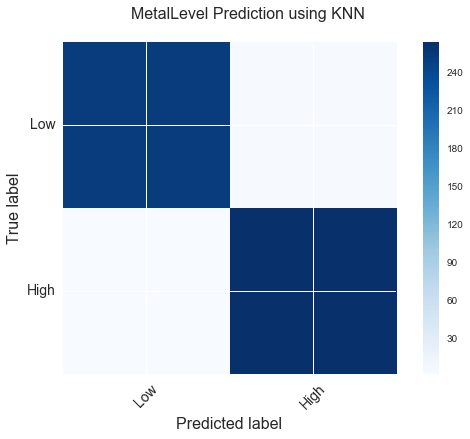

In [76]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

CVscores = cross_val_score(gs_model, df[colX], df['MetalLevel'], cv=cv)
print("CV Accuracy: %0.3f (+/- %0.3f)" % (CVscores.mean(), CVscores.std() * 1.96)) #95% confidence interval

labels = ['Low','High']
conf = confusion_matrix(y_test,predictions,labels)
acc = accuracy_score(y_test,predictions)

print ('Train/Test Accuracy:', acc, '\n')
print ('Confusion Matrix:')
print (conf)

plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf, 
                      title='        MetalLevel Prediction using KNN\n',
                      labels=labels)

For classification task 1, the K Nearest Neighbor model obtained an accuracy score of ~99%. However, we wish to optimize a linear classifier as well since it is easier to interpret the weights for the model vs kNN.

We will now attempt a Stochastic Gradient Descent model with a 70/30 split and 10 iterations for cross validation. The seed remains at 42.

## SGDClassifier

In [77]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100], 
              'loss':['hinge','log','modified_huber','squared_hinge','perceptron'], 
              'penalty' : ['l2','l1','elasticnet'], 
              'class_weight': ['balanced']}

We seperate out the continuous variables for scaling.  Once scaling is complete, the continuous variables are added back to the independent variable X.

In [78]:
sgd = SGDClassifier(n_jobs=-1)
gs = GridSearchCV(sgd, parameters, cv=cv)

scl_obj = StandardScaler()
scl_obj.fit(df[continuous])

X = scl_obj.transform(df[continuous])

X = pd.DataFrame(data = X, index = df[continuous].index, columns=continuous)

X = pd.concat([X,df[categorical]], axis=1)

gs.fit(X, df['MetalLevel'])

GridSearchCV(cv=ShuffleSplit(1742, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'class_weight': ['balanced'], 'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [79]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 1.00000, std: 0.00000, params: {'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.1},
 mean: 1.00000, std: 0.00000, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l1', 'alpha': 0.1},
 mean: 0.99885, std: 0.00344, params: {'class_weight': 'balanced', 'loss': 'perceptron', 'penalty': 'elasticnet', 'alpha': 0.1},
 mean: 0.99713, std: 0.00588, params: {'class_weight': 'balanced', 'loss': 'perceptron', 'penalty': 'l1', 'alpha': 0.1},
 mean: 0.95335, std: 0.13996, params: {'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 1},
 mean: 0.84990, std: 0.22175, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'elasticnet', 'alpha': 0.1},
 mean: 0.84226, std: 0.22648, params: {'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.1},
 mean: 0.84207, std: 0.23560, params: {'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.1},
 mean: 0.80631, std: 0.232

In [80]:
print (gs.best_score_, gs.best_params_)

1.0 {'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.1}


The highest average accuracy of the SGD model is 100% with a balanced class weight, a log and hinge loss, alpha equal to 0.1 and a penalty of 11.

We will apply the best parameters to the full data to see the model perform.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, df['MetalLevel'], 
                                                    test_size=0.30, random_state=42)

In [82]:
cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

In [83]:
gs_sgd = SGDClassifier(alpha=gs.best_params_['alpha'], 
                       loss=gs.best_params_['loss'], 
                       penalty=gs.best_params_['penalty'], 
                       class_weight=gs.best_params_['class_weight'])

CVscores = cross_val_score(gs_sgd, X, df['MetalLevel'], cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (CVscores.mean(), CVscores.std() * 1.96))

gs_sgd.fit(X_train, y_train)
yhat = gs_sgd.predict(X_test)

labels = ['Low','High']
conf = confusion_matrix(y_test, yhat, labels)
acc = accuracy_score(y_test, yhat)

print (conf)
print (acc)

Accuracy: 1.000 (+/- 0.000)
[[256   0]
 [  0 267]]
1.0


As can be seen above, when the best parameters are applied to the full data set, the 100% accuracy is still achieved.

We will plot the independent variables that have the most influence on our dependent variable.

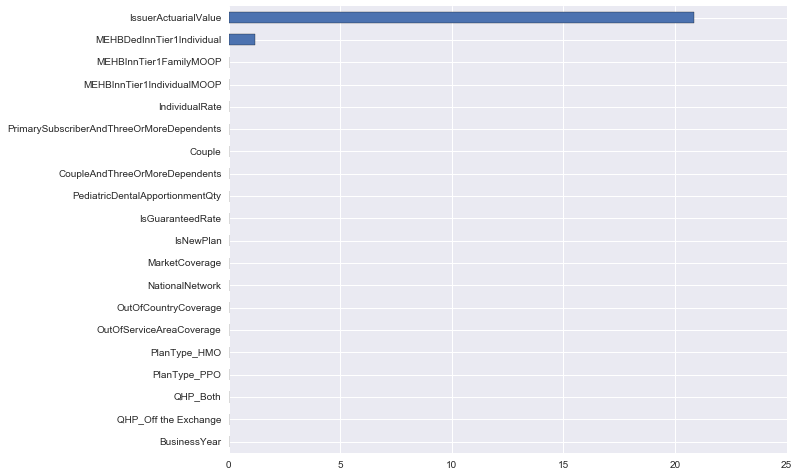

In [84]:
plt.figure(figsize=(10, 8))
weights = pd.Series(abs(gs_sgd.coef_[0]),index=colX)
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')

Below is a histogram of the IssuerActuarialValue. It is clear that it alone, can adequately distinguish the Metal Levels. The data dictionary points out that a plan is given an actuarial value based on its properties.

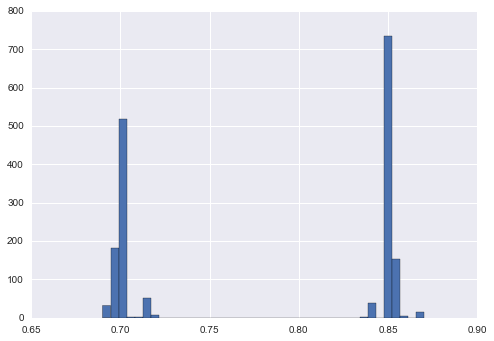

In [266]:
df.IssuerActuarialValue.hist(bins=40)

## Classification Task 2: Multi-class Classification of Metal Levels

In [85]:
#Resetting dataframe
df = df_join_RA

For the multi-class classification, we will exclude the 'Family Option' from the dataset as we covered this in the previous classification task. There are 5 Metal Levels associated with Individual Health Plans. 

In the data dictionary, we also discovered that we can eliminate dental only plans for this task and we also do not wish to include small business options. 

We will only focus on Individual Plans here. Due to processing times, we will only focus on plans from 2016, which gives us a ~300K dataset

In [86]:
df = df[df['Age'] != 66] #Removing the 'FamilyOption' designated by Age = 66
df = df[df['DentalOnlyPlan'] == 0] # Not a Dental Plan Only = 0, DentalOnlyPlan = 1
df = df[df['MarketCoverage'] == 0] # Individual = 0, Small Group = 1
df = df[df['BusinessYear'] == 2016] #limiting the dataset size to 2016 plans

In [87]:
df.shape

(311282, 149)

In [88]:
df.groupby('MetalLevel')['key','BusinessYear'].count()

key  BusinessYear
MetalLevel                        
Bronze         60858         60858
Catastrophic    5198          5198
Gold           39744         39744
Platinum        7452          7452
Silver        198030        198030

The attributes below may be one-hot encoded.

In [89]:
df.groupby('PlanType')['key','BusinessYear'].count()

key  BusinessYear
PlanType                      
EPO        70932         70932
HMO       208334        208334
POS        14628         14628
PPO        17388         17388

In [90]:
df.groupby('QHPNonQHPTypeId')['key','BusinessYear'].count()

key  BusinessYear
QHPNonQHPTypeId                      
Both             297298        297298
On the Exchange   13984         13984

In [91]:
tmp_df = pd.get_dummies(df.PlanType,prefix='PlanType')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.QHPNonQHPTypeId,prefix='QHP')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [92]:
#Renaming a few columns for brevity
df = df.rename(columns = {'BeginPrimaryCareCostSharingAfterNumberOfVisits':'BeginCostSharingAfterNumberOfVisits'})
df = df.rename(columns = {'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays':'BeginDedCoinsAfterNumberOfCopays'})
df = df.rename(columns = {'EHBPediatricDentalApportionmentQuantity':'PediatricDentalApportionmentQty'})
df = df.rename(columns = {'InpatientCopaymentMaximumDays':'InpatientCopayMaxDays'})

As we can see in the summary below, a high number of missing values remain. We will move forward with attributes that contain no null values and attributes that have at least 50% of values available. The choice of 50% is a lower bound that the team felt was acceptable for imputing. Generally, we observed poor/biased distributions when we imputed attributes with less than 50% available data.

In [93]:
#Data Summary by Column, Null v Not Null Counts
print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format('Data Type','   Null', 'Not Null', 'Not Null %','','Column Name'))
for column in df.columns:
    print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:8}'.format(df[column].dtype,
                                                         df[column].isnull().sum(), 
                                                         df[column].notnull().sum(),
                                                         round(df[column].notnull().sum()/df[column].notnull().count(),3),
                                                         ' ',column))

Data Type    Null  Not Null Not Null %      Column Name
int64           0   311282      1.0      BusinessYear
object          0   311282      1.0      StateCode
int64           0   311282      1.0      IssuerId
object          0   311282      1.0      PlanId  
int64           0   311282      1.0      Tobacco 
float64         0   311282      1.0      Age     
float64         0   311282      1.0      IndividualRate
float64     11316   299966    0.964      IndividualTobaccoRate
float64    311282        0      0.0      PrimarySubscriberAndOneDependent
float64    311282        0      0.0      PrimarySubscriberAndTwoDependents
float64    311282        0      0.0      PrimarySubscriberAndThreeOrMoreDependents
float64    311282        0      0.0      Couple  
float64    311282        0      0.0      CoupleAndOneDependent
float64    311282        0      0.0      CoupleAndTwoDependents
float64    311282        0      0.0      CoupleAndThreeOrMoreDependents
object          0   311282      1.0    

The attributes below have no missing values

In [94]:
noNeed = ['BusinessYear','IssuerId'] #In this case, BusinessYear is added to the list as we are only looking at 2016.
noNulls = []
for column in df.columns:
    if ((df[column].notnull().sum()/df[column].notnull().count() == 1) and (df[column].dtype != 'object')
       and (column not in noNeed)):
        print ('{0:6} {1:20}'.format(df[column].notnull().sum()/df[column].notnull().count(),column))
        noNulls.append(column)

   1.0 Tobacco             
   1.0 Age                 
   1.0 IndividualRate      
   1.0 BeginCostSharingAfterNumberOfVisits
   1.0 BeginDedCoinsAfterNumberOfCopays
   1.0 ChildOnlyOffering   
   1.0 CompositeRatingOffered
   1.0 DentalOnlyPlan      
   1.0 EHBPercentTotalPremium
   1.0 FirstTierUtilization
   1.0 InpatientCopayMaxDays
   1.0 IsHSAEligible       
   1.0 IsNewPlan           
   1.0 IsNoticeRequiredForPregnancy
   1.0 IsReferralRequiredForSpecialist
   1.0 MarketCoverage      
   1.0 MedicalDrugDeductiblesIntegrated
   1.0 MedicalDrugMaximumOutofPocketIntegrated
   1.0 MultipleInNetworkTiers
   1.0 NationalNetwork     
   1.0 OutOfCountryCoverage
   1.0 OutOfServiceAreaCoverage
   1.0 UniquePlanDesign    
   1.0 WellnessProgramOffered
   1.0 SBCHavingDiabetesCoinsurance
   1.0 SBCHavingaBabyCoinsurance
   1.0 TEHBInnTier1IndividualMOOP
   1.0 TEHBInnTier1FamilyPerGroupMOOP
   1.0 TEHBInnTier1FamilyPerPersonMOOP
   1.0 SBCHavingDiabetesCopayment
   1.0 SBCHavingDiabetes

The following 5 attributes have at least 50% of their data available and will thus be imputed with their medians

In [95]:
imputed = []
for column in df.columns:
    if ((column not in noNulls) and (df[column].dtype != 'object') and (column not in noNeed)
       and ( df[column].notnull().sum()/df[column].notnull().count() > 0.5 )):
        print ('{0:6} {1:20}'.format(round(df[column].notnull().sum()/df[column].notnull().count(),4),column))
        imputed.append(column)

0.9636 IndividualTobaccoRate
0.5717 TEHBDedInnTier1Coinsurance
0.5717 TEHBDedInnTier1Individual
0.5717 TEHBDedInnTier1FamilyPerGroup
0.5611 TEHBDedInnTier1FamilyPerPerson


In [96]:
df.IndividualTobaccoRate = df.IndividualTobaccoRate.fillna(df.IndividualTobaccoRate.median()) #median
df.TEHBDedInnTier1Coinsurance = df.TEHBDedInnTier1Coinsurance.fillna(df.TEHBDedInnTier1Coinsurance.median()) #median
df.TEHBDedInnTier1Individual = df.TEHBDedInnTier1Individual.fillna(df.TEHBDedInnTier1Individual.median()) #median
df.TEHBDedInnTier1FamilyPerGroup = df.TEHBDedInnTier1FamilyPerGroup.fillna(df.TEHBDedInnTier1FamilyPerGroup.median()) #median
df.TEHBDedInnTier1FamilyPerPerson = df.TEHBDedInnTier1FamilyPerPerson.fillna(df.TEHBDedInnTier1FamilyPerPerson.median()) #median

### We now have a preliminary list, colX, of attributes to build a supervised classification model.

In [97]:
colX = noNulls + imputed

We will inspect attributes to define them as continuous, categorical, or oneLevel by looking at the number of distinct values that appear in the attribute. oneLevel attributes will not move forward in the analysis as they offer no information in the classification process. 

In [98]:
#establish arrays for continuous, one level and categorical variables
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)

     2 Categorical  int64      Tobacco             
    46 Continuous   float64    Age                 
 48112 Continuous   float64    IndividualRate      
     5 Continuous   float64    BeginCostSharingAfterNumberOfVisits
     4 Continuous   float64    BeginDedCoinsAfterNumberOfCopays
     2 Categorical  float64    ChildOnlyOffering   
     1 One Level    float64    CompositeRatingOffered
     1 One Level    float64    DentalOnlyPlan      
    60 Continuous   float64    EHBPercentTotalPremium
     3 Continuous   float64    FirstTierUtilization
     3 Continuous   float64    InpatientCopayMaxDays
     2 Categorical  float64    IsHSAEligible       
     2 Categorical  float64    IsNewPlan           
     2 Categorical  float64    IsNoticeRequiredForPregnancy
     2 Categorical  float64    IsReferralRequiredForSpecialist
     1 One Level    float64    MarketCoverage      
     2 Categorical  float64    MedicalDrugDeductiblesIntegrated
     1 One Level    float64    MedicalDrugMaximumOuto

In [99]:
#adding the columns that will be used for analysis
#these are the independent variables
#this excludes the One Level variables
colX = continuous + categorical

### Attribute Analysis - Collinearity

(31128, 23)


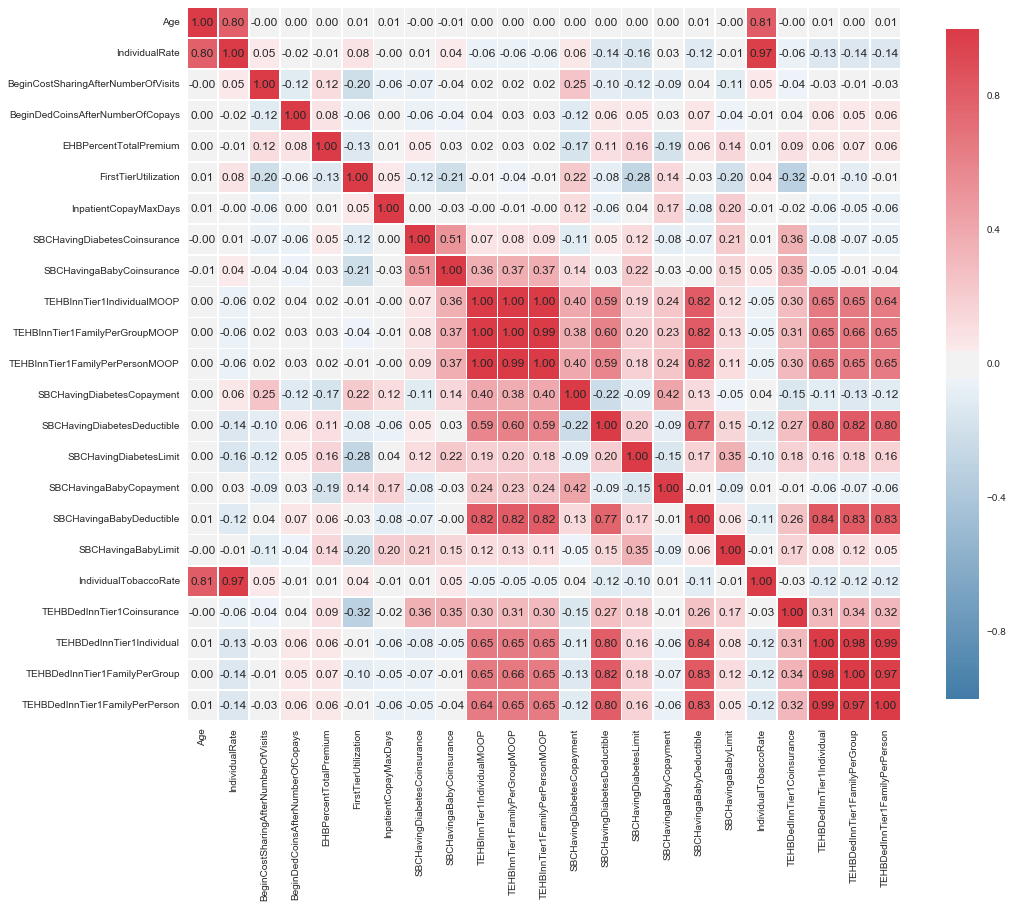

In [100]:
tmp = df[continuous].sample(frac=0.1) #sampled 10% to save time in drawing correlation matrix
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')

The above correlation matrix shows a large amount of collinearity between a couple of the attributes, 97%+ Pearson's Correlation. Five attributes will be removed for modeling as they appear to be redundant. The attributes are listed below. 

We will create a temporary array for the attributes that we wish to keep in the model by removing attributes showed the highest collinearity.  We will then repeat the process of creating arrays for the continuous and categorical variables (An update). 

In [101]:
collinear = ['TEHBInnTier1FamilyPerGroupMOOP','TEHBInnTier1FamilyPerPersonMOOP',
             'TEHBDedInnTier1FamilyPerGroup','TEHBDedInnTier1FamilyPerPerson',
             'IndividualTobaccoRate']

tmp = []
for col in colX:
    if col not in collinear:
        tmp.append(col)
        
colX = tmp

In [102]:
continuous = []
categorical = []
oneLevel = []
for col in colX:
    if df[col].unique().size > 2:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Continuous', df[col].dtype ,col))
        continuous.append(col)
    elif df[col].unique().size == 1:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'One Level', df[col].dtype ,col))
        oneLevel.append(col)
    else:
        print('{0:6} {1:12} {2!s:10} {3:20}'.format(df[col].unique().size,'Categorical', df[col].dtype ,col))
        categorical.append(col)

    46 Continuous   float64    Age                 
 48112 Continuous   float64    IndividualRate      
     5 Continuous   float64    BeginCostSharingAfterNumberOfVisits
     4 Continuous   float64    BeginDedCoinsAfterNumberOfCopays
    60 Continuous   float64    EHBPercentTotalPremium
     3 Continuous   float64    FirstTierUtilization
     3 Continuous   float64    InpatientCopayMaxDays
    80 Continuous   float64    SBCHavingDiabetesCoinsurance
   132 Continuous   float64    SBCHavingaBabyCoinsurance
    81 Continuous   float64    TEHBInnTier1IndividualMOOP
   105 Continuous   float64    SBCHavingDiabetesCopayment
    81 Continuous   float64    SBCHavingDiabetesDeductible
     6 Continuous   float64    SBCHavingDiabetesLimit
    53 Continuous   float64    SBCHavingaBabyCopayment
   119 Continuous   float64    SBCHavingaBabyDeductible
     5 Continuous   float64    SBCHavingaBabyLimit 
    11 Continuous   float64    TEHBDedInnTier1Coinsurance
    84 Continuous   float64    TEHBDedI

(31128, 18)


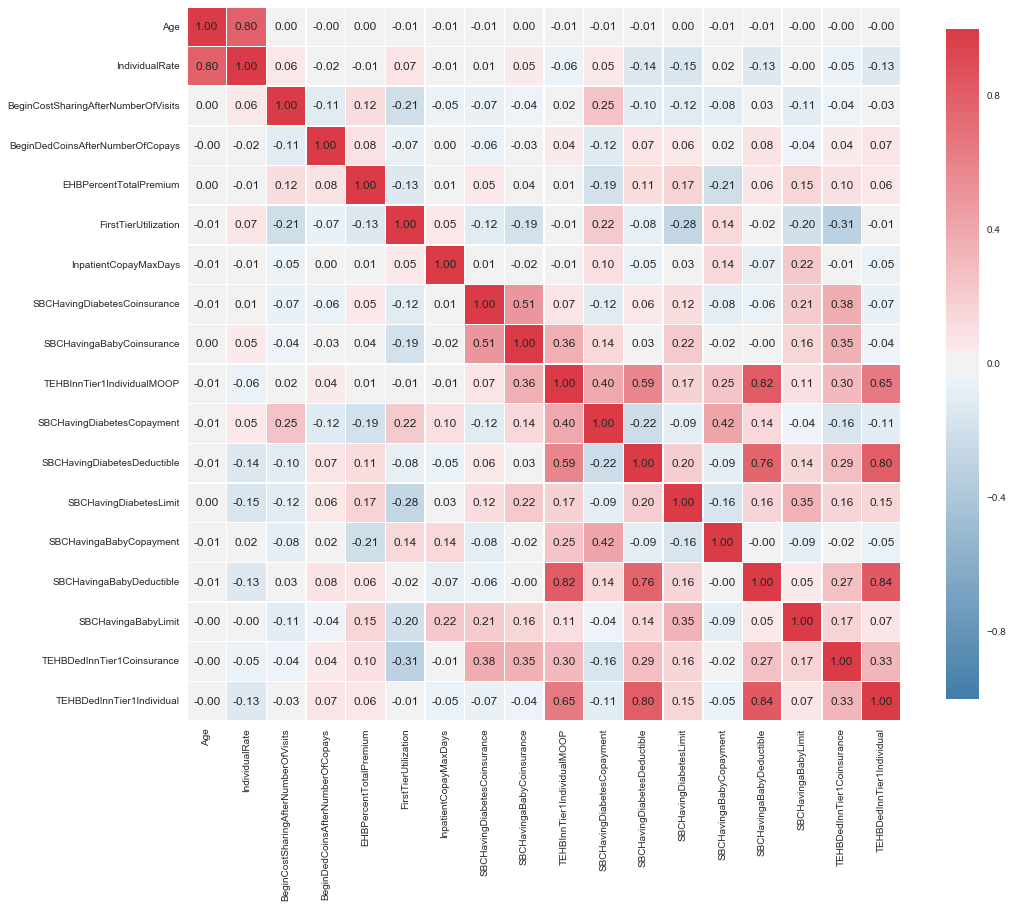

In [103]:
tmp = df[continuous].sample(frac=0.1)
print (tmp.shape)

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = True, fmt = '.2f')

### Based on the updated correlation matrix, we have reduced the collinearity by removing specific attributes. We are now ready to begin building models with these updated set of attributes.

In [105]:
colX = continuous + categorical

### To speed up the grid search process, we randomly sampled 30% of the available data. This will assist us in finding optimal model parameters. Once the parameters are determined, we will build models using the entire dataset

In [106]:
#we randomly downsample to speed up the grid search process
downsample = df.sample(frac=0.3)
print (downsample.shape)

(93385, 155)


### Perform GridSearch for SGDClassifier

In [107]:
cv = ShuffleSplit(n = len(downsample), n_iter=10, test_size=0.3, random_state=42)

parameters = {'alpha': [0.0001, 0.01, 0.1, 1, 10, 100], 
              'loss':['hinge','log','modified_huber','squared_hinge','perceptron'], 
              'penalty' : ['l2','l1','elasticnet'], 
              'class_weight': ['balanced']}

Before we run the grid search process, we made sure that the continuous variables are the only ones being scaled by the StandardScaler. Once we apply the StandardScaler on the continuous variables, we then concatenate the scaled data with the categorical data and pass it to the GridSearch process. If we had applied the StandardScaler on all the data, the binary categorical attributes would have been shifted and normalized.

In [108]:
sgd = SGDClassifier(n_jobs=-1)
gs = GridSearchCV(sgd, parameters, cv=cv)

scl_obj = StandardScaler()
scl_obj.fit(downsample[continuous])

X = scl_obj.transform(downsample[continuous])

X = pd.DataFrame(data = X, index = downsample[continuous].index, columns=continuous)

X = pd.concat([X,downsample[categorical]], axis=1)

gs.fit(X, downsample['MetalLevel'])

GridSearchCV(cv=ShuffleSplit(93385, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'class_weight': ['balanced'], 'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [109]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True) #sorted grid scores

[mean: 0.73005, std: 0.01881, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l1', 'alpha': 0.0001},
 mean: 0.72541, std: 0.00769, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'elasticnet', 'alpha': 0.0001},
 mean: 0.71784, std: 0.00977, params: {'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.01},
 mean: 0.71609, std: 0.00334, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l2', 'alpha': 0.01},
 mean: 0.71517, std: 0.00695, params: {'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.01},
 mean: 0.71482, std: 0.00306, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l1', 'alpha': 0.01},
 mean: 0.71425, std: 0.00444, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'elasticnet', 'alpha': 0.01},
 mean: 0.71389, std: 0.02029, params: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l2', 'alpha': 0.0001},
 mean: 0.71335, std: 0.00936

In [110]:
print (gs.best_score_, gs.best_params_) #best grid score with corresponding parameters

0.730054254712 {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l1', 'alpha': 0.0001}


### Build an SGD Classifier model with the optimal GridSearch parameter values and assess accuracy score

### In this case, we use the entire dataset, not the downsample

In [111]:
scl_obj = StandardScaler()
scl_obj.fit(df[continuous])

X = scl_obj.transform(df[continuous])

X = pd.DataFrame(data = X, index=df[continuous].index, columns=continuous)

X = pd.concat([X, df[categorical]],axis=1)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, df['MetalLevel'], 
                                                    test_size=0.30, random_state=42)

cv = ShuffleSplit(n = len(df['MetalLevel']), n_iter=10, test_size=0.3, random_state=42) #for cross validation

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, df['MetalLevel'], 
                                                    test_size=0.30, random_state=42)

gs_sgd = SGDClassifier(alpha=gs.best_params_['alpha'], 
                       loss=gs.best_params_['loss'], 
                       penalty=gs.best_params_['penalty'], 
                       class_weight=gs.best_params_['class_weight'])

scores = cross_val_score(gs_sgd, X, df['MetalLevel'], cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gs_sgd.fit(X_train, y_train)
yhat = gs_sgd.predict(X_test)

labels = ['Catastrophic','Bronze','Silver','Gold','Platinum']
conf = confusion_matrix(y_test, yhat, labels)
acc = accuracy_score(y_test, yhat)

print (conf)
print (acc)

Accuracy: 0.733 (+/- 0.021)
[[ 1597    20     8     0     0]
 [  368 12188  4821   740   116]
 [    0  6484 45567  6540   863]
 [    0  1157  3641  6558   510]
 [    0     3    94    91  2019]]
0.727408041977


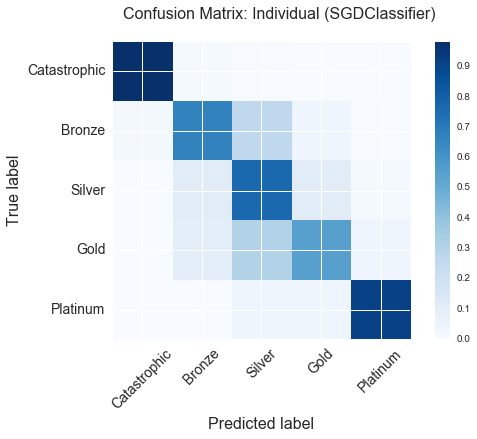

In [115]:
plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Confusion Matrix: Individual (SGDClassifier)\n',
                      labels=labels)

The SGDClassifier generates a set of weights for each class (One-vs-All approach). To determine which attributes are most influential in this model, we normalized each weight set and plotted the weights by attribute for the 5 classes on the same bar plot. Visually there is no clear indication that 1 or a couple of attributes are most important. We also ran a Recursive Feature Elimination (RFE) function on the data but the top 10 features do not seem to reflect what we see visually. It appears that the RFE may only operate on one of the set of weights. 

We will try a random forests classfier next and take a look at its feature importances to see if theres a better relationship. 

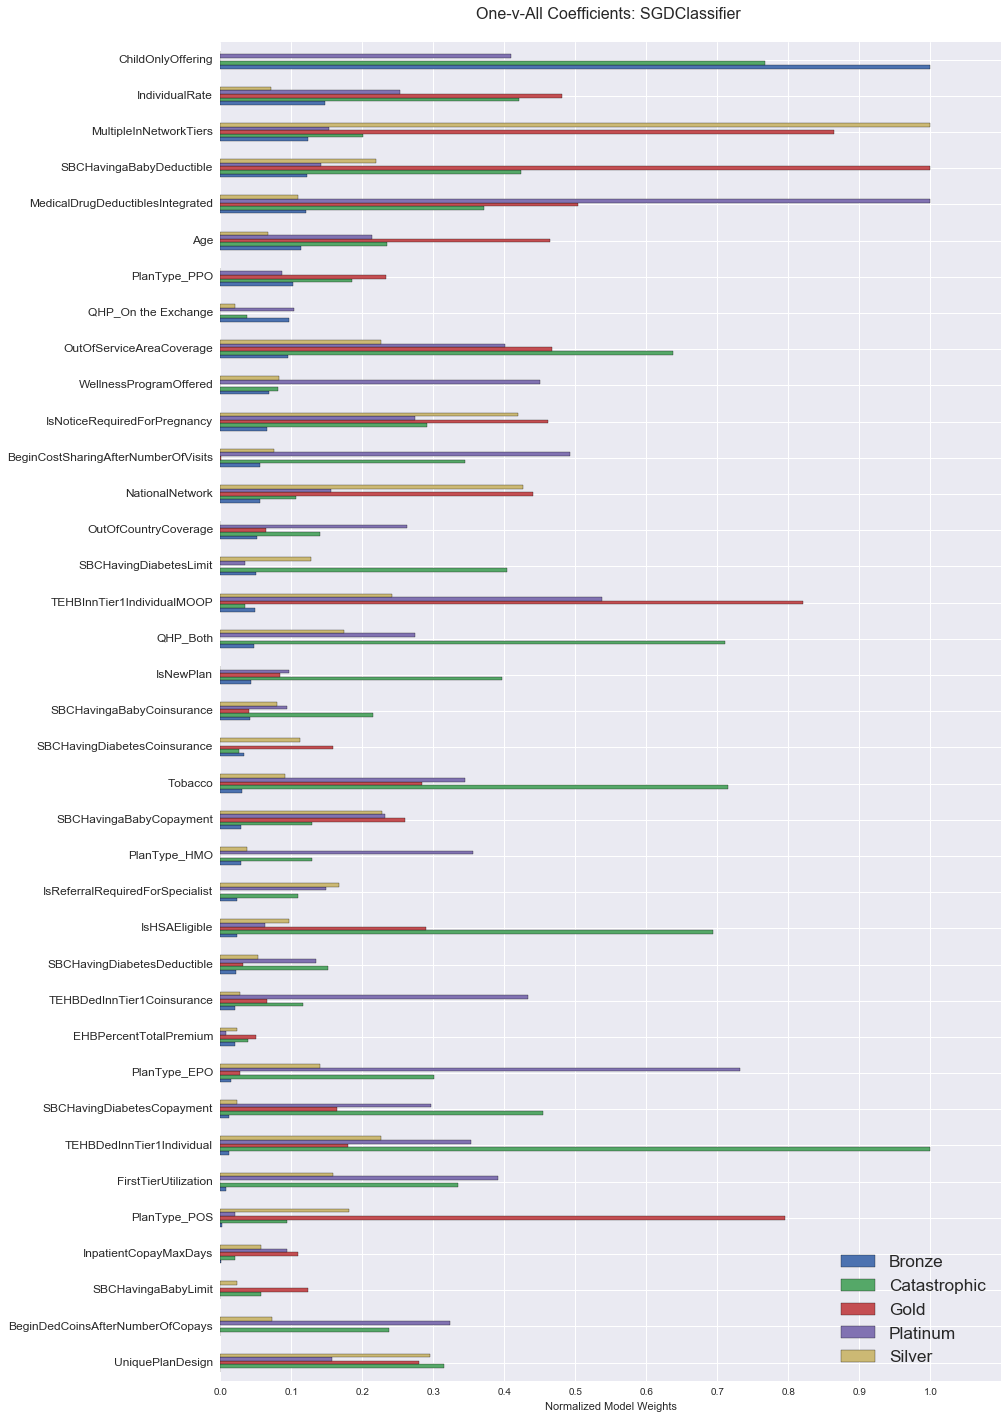

In [116]:
weights = []
for metal in range(0, len(gs_sgd.classes_)):
    weights.append(pd.Series(abs(gs_sgd.coef_[metal]),index=colX))

allWeights = pd.concat(weights,axis=1)

for metal in range(0, len(gs_sgd.classes_)):
    allWeights = allWeights.rename(columns={metal:gs_sgd.classes_[metal]})
    allWeights[gs_sgd.classes_[metal]] = allWeights[gs_sgd.classes_[metal]]/abs(allWeights[gs_sgd.classes_[metal]]).max()

    
allWeights.sort_values('Bronze',ascending=True).plot(kind='barh',stacked=False,figsize=(14,24))

# allWeights.sort_values('Silver',ascending=True).plot(kind='barh',stacked=False,figsize=(14,24),
#                                                      colors=['#cd7f32','#8A0707','#ffd700','#F0F0F0','#606060'])

plt.xlim([0,1.1])
plt.xticks(np.arange(0, 1.05, .1))
plt.yticks(fontsize=12)
plt.title('One-v-All Coefficients: SGDClassifier \n', fontsize = 16)
plt.xlabel('Normalized Model Weights')
plt.legend(loc='best', fontsize = 'x-large',)

### RFE Analysis 

In [117]:
rfe = RFE(estimator=gs_sgd, n_features_to_select=10, step=1)
rfe.fit(X,df['MetalLevel'])

RFE(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
  estimator_params=None, n_features_to_select=10, step=1, verbose=0)

In [118]:
features = []
for i in range(0,len(colX)):
    if rfe.support_[i] == True:
        features.append(colX[i])

### These features appear to be most associated with either the Platinum or Catastrophic Metal Levels.

In [119]:
print (features)

['BeginCostSharingAfterNumberOfVisits', 'FirstTierUtilization', 'SBCHavingDiabetesCopayment', 'TEHBDedInnTier1Individual', 'Tobacco', 'ChildOnlyOffering', 'IsHSAEligible', 'MedicalDrugDeductiblesIntegrated', 'PlanType_EPO', 'QHP_Both']


## Classification with RandomForests

In [120]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=10, test_size=0.3, random_state=42)

parameters = {'n_estimators': [5,10,15,20,25],
              'criterion':['gini','entropy'],
              'max_features':['sqrt','log2'],
              'class_weight': ['balanced']}

In [121]:
rf = RandomForestClassifier(n_jobs=-1)
gsrf = GridSearchCV(rf, parameters, cv=cv)

gsrf.fit(downsample[colX], downsample['MetalLevel'])

GridSearchCV(cv=ShuffleSplit(93385, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [5, 10, 15, 20, 25], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [122]:
sorted(gsrf.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.95789, std: 0.00073, params: {'criterion': 'entropy', 'n_estimators': 25, 'max_features': 'sqrt', 'class_weight': 'balanced'},
 mean: 0.95789, std: 0.00092, params: {'criterion': 'entropy', 'n_estimators': 20, 'max_features': 'log2', 'class_weight': 'balanced'},
 mean: 0.95783, std: 0.00106, params: {'criterion': 'gini', 'n_estimators': 25, 'max_features': 'log2', 'class_weight': 'balanced'},
 mean: 0.95780, std: 0.00104, params: {'criterion': 'gini', 'n_estimators': 20, 'max_features': 'sqrt', 'class_weight': 'balanced'},
 mean: 0.95763, std: 0.00095, params: {'criterion': 'gini', 'n_estimators': 25, 'max_features': 'sqrt', 'class_weight': 'balanced'},
 mean: 0.95761, std: 0.00082, params: {'criterion': 'gini', 'n_estimators': 20, 'max_features': 'log2', 'class_weight': 'balanced'},
 mean: 0.95758, std: 0.00085, params: {'criterion': 'entropy', 'n_estimators': 25, 'max_features': 'log2', 'class_weight': 'balanced'},
 mean: 0.95756, std: 0.00105, params: {'criterion': 'entropy

In [123]:
print (gsrf.best_score_, gsrf.best_params_)

0.957888349515 {'criterion': 'entropy', 'n_estimators': 25, 'max_features': 'sqrt', 'class_weight': 'balanced'}


### We will now fit a Random Forests model with the entire dataset given the optimal grid search parameters

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df[colX], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

In [125]:
gsrf_model = RandomForestClassifier(n_estimators = gsrf.best_params_['n_estimators'],
                                    criterion = gsrf.best_params_['criterion'],
                                 max_features = gsrf.best_params_['max_features'],
                                 class_weight = gsrf.best_params_['class_weight'],
                                   n_jobs=-1)

scores = cross_val_score(gsrf_model, df[colX] , df['MetalLevel'], cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gsrf_model.fit(X_train,y_train)
yhat = gsrf_model.predict(X_test)

conf = confusion_matrix(y_test,yhat,labels)
acc = accuracy_score(y_test,yhat)

print (conf)
print (acc)

Accuracy: 0.979 (+/- 0.001)
[[ 1625     0     0     0     0]
 [    0 17355   850    28     0]
 [    0   805 57985   653    11]
 [    0    38   614 10997   217]
 [    0     0    13   172  2022]]
0.963580874873


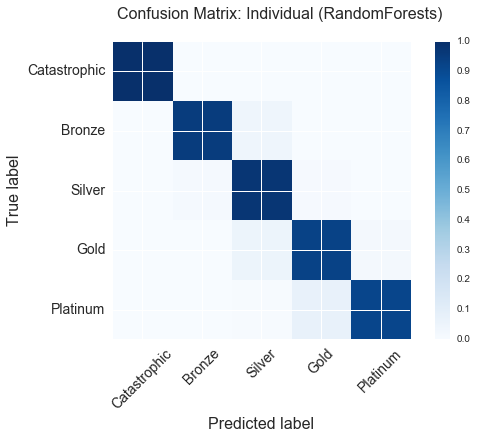

In [126]:
plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Confusion Matrix: Individual (RandomForests)\n',
                      labels=labels)

Given the high accuracy achieved, the bar plot of the feature importances shows that the Maximum out of pocket, deductibles, and individual premium rates are most important in classifying the metal levels. It is interesting to note that most of the categorical variables are not as influential as they appear to be in the linear SGD classifier model. 

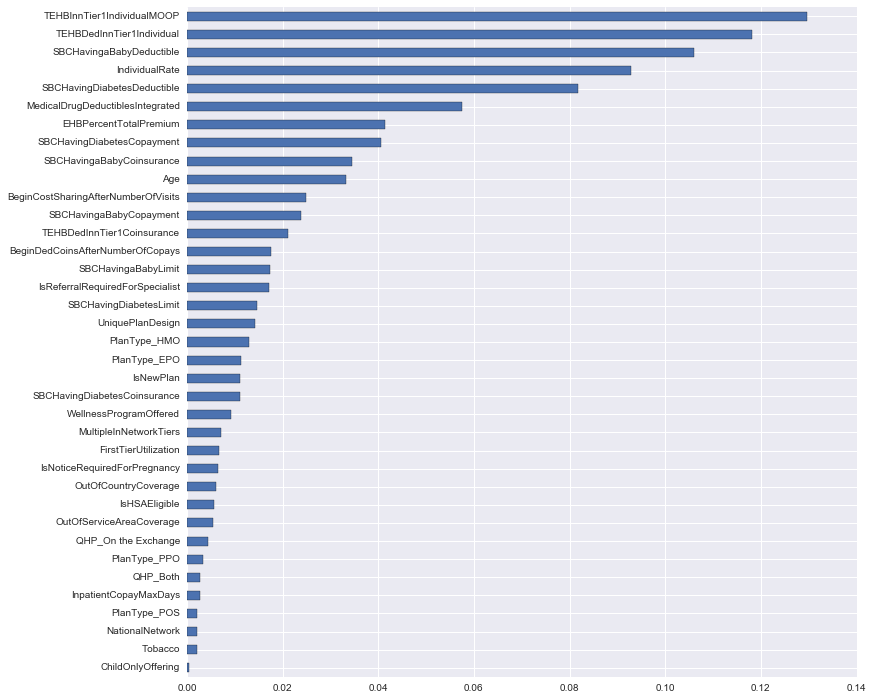

In [197]:
plt.figure(figsize=(12, 12))
weights = pd.Series(gsrf_model.feature_importances_,index=colX)
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')

### In running an RFE with the random forests model, we do get a set of attributes that very much agrees with the feature importances. 

In [127]:
rfe = RFE(estimator=gsrf_model, n_features_to_select=10, step=1)
rfe.fit(df[colX],df['MetalLevel'])

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  estimator_params=None, n_features_to_select=10, step=1, verbose=0)

In [128]:
features = []
for i in range(0,len(colX)):
    if rfe.support_[i] == True:
        features.append(colX[i])

In [129]:
print (features)

['Age', 'IndividualRate', 'EHBPercentTotalPremium', 'TEHBInnTier1IndividualMOOP', 'SBCHavingDiabetesCopayment', 'SBCHavingDiabetesDeductible', 'SBCHavingaBabyDeductible', 'SBCHavingaBabyLimit', 'TEHBDedInnTier1Individual', 'MedicalDrugDeductiblesIntegrated']


### Weight Comparison Plots

### When we compare the feature importances from Random Forests and the OVA weights from the SGD classifier in a bar plot, we see that there is some agreement between the models in terms of which attributes are most important. This mostly occurs with the continuous variables. The most disagreement is seen with the categorical variables. The plot below is sorted by Random Forest importances. 

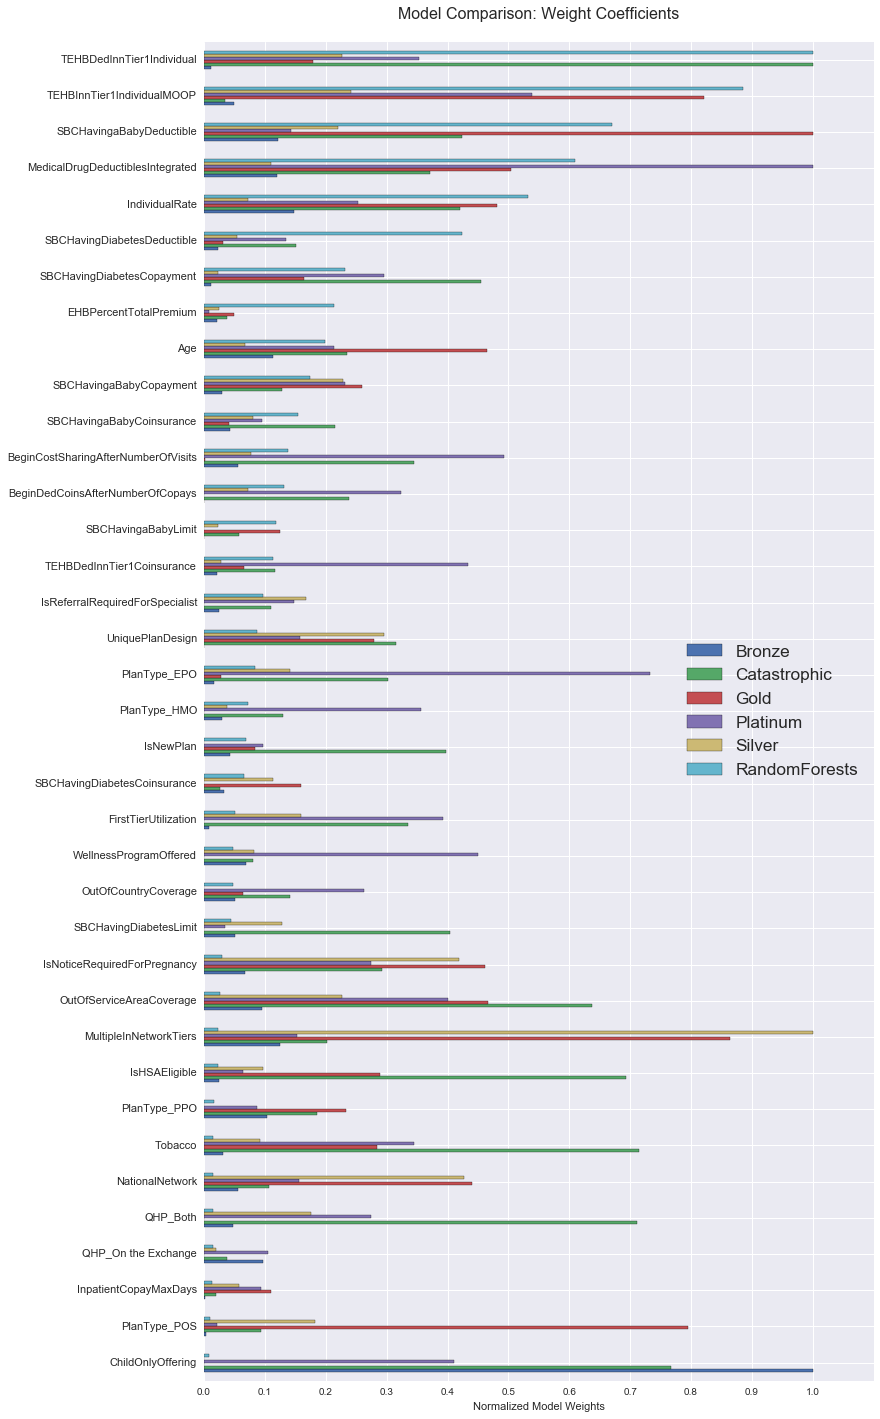

In [130]:
SGDweights = allWeights
weightsRF = pd.Series(gsrf_model.feature_importances_,index=colX)

allWeights = pd.concat([SGDweights,weightsRF],axis=1)
allWeights = allWeights.rename(columns={0:'RandomForests'})

allWeights['RandomForests'] = allWeights.RandomForests/allWeights.RandomForests.max()

allWeights.sort_values('RandomForests', ascending=True).plot(kind='barh',stacked=False,figsize=(12,24))
plt.xlim([0,1.1])
plt.xticks(np.arange(0, 1.05, .1))
plt.yticks(fontsize=11)
plt.title('Model Comparison: Weight Coefficients\n', fontsize = 16)
plt.xlabel('Normalized Model Weights')
plt.legend(loc='best', fontsize = 'x-large')

### We will now try KNN Classifier

### We dropped the ShuffleSplit cv folds to 3 from 10 because knn is computationally intensive. Similarly, we restricted the n neighbors numbers to odd values to break ties and to reduce the neighbor values to try. To run the grid search we are also using downsampled data as before. 

In [132]:
cv = ShuffleSplit(n = len(downsample['MetalLevel']), n_iter=3, test_size=0.3, random_state=42)

parameters = {'n_jobs': [-1],
              'n_neighbors': [1, 3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'minkowski']}

In [133]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters, cv=cv, n_jobs=-1, verbose=10)

gs.fit(downsample[colX], downsample['MetalLevel'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.893525 -   8.6s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.893525 -   9.2s
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.892847 -   9.5s
[CV] n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=uniform, n_jobs=-1, score=0.896274 -   9.5s
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV] n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.0s


[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.889670 -  10.0s
[CV] n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.892097 -  10.4s
[CV] n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metric=euclidean, weights=distance, n_jobs=-1, score=0.896274 -  10.7s
[CV] n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=euclidean, weights=uniform, n_jobs=-1, score=0.895595 -  10.2s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.894382 -  10.6s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.0s


[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.893597 -  10.9s
[CV] n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, metric=euclidean, weights=distance, n_jobs=-1, score=0.898915 -  11.2s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.889706 -   9.7s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.888492 -   8.6s
[CV] n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1, score=0.895988 -   9.2s
[CV] n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=euclidean, weights=uniform, n_jobs=-1, score=0.892990 -   9.6s
[CV] n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metr

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.8s


[CV]  n_neighbors=5, metric=euclidean, weights=distance, n_jobs=-1, score=0.898736 -   8.8s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.889563 -   9.2s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.887921 -   9.2s
[CV] n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metric=euclidean, weights=uniform, n_jobs=-1, score=0.892740 -   9.4s
[CV] n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.895774 -  10.0s
[CV] n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.898558 -   9.3s
[CV]  n_neighbors=7, metric=euclidean, weights=distance, n_jobs=-1, score=0.895024 -   9.4s
[CV]

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min


[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.888956 -   9.4s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.887671 -   8.4s
[CV] n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=9, metric=euclidean, weights=uniform, n_jobs=-1, score=0.891348 -   9.3s
[CV] n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1, score=0.894846 -   9.3s
[CV] n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1, score=0.894703 -   9.0s
[CV] n_neighbors=1, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=9, metric=euclidean, weights=distance, n_jobs=-1, score=0.898629 -   8.7s
[CV] n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=1, metr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.893525 -   9.3s
[CV] n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.892847 -   8.7s
[CV] n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=1, metric=minkowski, weights=distance, n_jobs=-1, score=0.896274 -   9.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1, score=0.892097 -   8.2s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=uniform, n_jobs=-1, score=0.889670 -   8.1s
[CV] n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=3, metric=minkowski, weights=distance, n_jobs=-1, score=0.894382 -   8.4s
[CV] n_neighbors=5, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=3, met

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min


[CV]  n_neighbors=5, metric=minkowski, weights=uniform, n_jobs=-1, score=0.889706 -   8.7s
[CV]  n_neighbors=5, metric=minkowski, weights=uniform, n_jobs=-1, score=0.888492 -   8.6s
[CV] n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV] n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=5, metric=minkowski, weights=uniform, n_jobs=-1, score=0.892990 -   8.9s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.895988 -   8.8s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.894989 -   8.9s
[CV] n_neighbors=7, metric=minkowski, weights=uniform, n_jobs=-1 .....
[CV]  n_neighbors=5, metric=minkowski, weights=distance, n_jobs=-1, score=0.898736 -   9.2s
[CV] n_neighbors=7, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV]  n_neighbors=7, metr

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.1min


[CV]  n_neighbors=7, metric=minkowski, weights=distance, n_jobs=-1, score=0.898558 -   9.0s
[CV] n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1 ....


[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.1min remaining:   -2.1s


[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.888956 -   9.2s
[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.887671 -   8.8s
[CV] n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1 ....
[CV] n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1 ....


[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.2min remaining:   -2.2s
[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.2min remaining:   -2.2s


[CV]  n_neighbors=9, metric=minkowski, weights=uniform, n_jobs=-1, score=0.891348 -   8.5s


[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.3min remaining:   -2.2s


[CV]  n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1, score=0.894846 -   8.3s


[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.3min remaining:   -2.3s


[CV]  n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1, score=0.894703 -   7.6s
[CV]  n_neighbors=9, metric=minkowski, weights=distance, n_jobs=-1, score=0.898629 -   7.7s


[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.3min remaining:   -2.3s
[Parallel(n_jobs=-1)]: Done  61 out of  60 | elapsed:  2.3min remaining:   -2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


GridSearchCV(cv=ShuffleSplit(93385, n_iter=3, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'minkowski'], 'n_neighbors': [1, 3, 5, 7, 9], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [134]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.89657, std: 0.00158, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 5, 'n_jobs': -1},
 mean: 0.89657, std: 0.00158, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 5, 'n_jobs': -1},
 mean: 0.89645, std: 0.00152, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 7, 'n_jobs': -1},
 mean: 0.89645, std: 0.00152, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 7, 'n_jobs': -1},
 mean: 0.89606, std: 0.00182, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 9, 'n_jobs': -1},
 mean: 0.89606, std: 0.00182, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 9, 'n_jobs': -1},
 mean: 0.89563, std: 0.00234, params: {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 3, 'n_jobs': -1},
 mean: 0.89563, std: 0.00234, params: {'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 3, 'n_jobs': -1},
 mean: 0.89422, std: 0.00148, params: {'weights': 'unifo

In [135]:
print (gs.best_score_, gs.best_params_)

0.896571007044 {'weights': 'distance', 'metric': 'euclidean', 'n_neighbors': 5, 'n_jobs': -1}


## The best average accuracy of the K Nearest Neighbor model on the downsample data set is 89.7%, with a euclidean metric, n neighbors of 5, and weights of distance.
## We will now apply these best parameters to the full data set.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df[colX], 
                                                    df['MetalLevel'], 
                                                    test_size=0.30,random_state=42)

gs_knn = KNeighborsClassifier(metric = gs.best_params_['metric'],
                                 n_neighbors = gs.best_params_['n_neighbors'],
                                 weights = gs.best_params_['weights'],
                                   n_jobs=-1)

scores = cross_val_score(gs_knn, df[colX] , df['MetalLevel'], cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

gs_knn.fit(X_train, y_train)
yhat = gs_knn.predict(X_test)

conf = confusion_matrix(y_test,yhat,labels)
acc = accuracy_score(y_test,yhat)

print (conf)
print (acc)

Accuracy: 0.931 (+/- 0.001)
[[ 1588    37     0     0     0]
 [   38 16153  1783   257     2]
 [    0  1703 56302  1386    63]
 [    0   299  1915  9417   235]
 [    0     2   125   219  1861]]
0.91364780211


## Applied to the full data set, the K Nearest Neighbors has a slightly better accuracy score of 91.3%.
## We will now plot the confusion matrix.

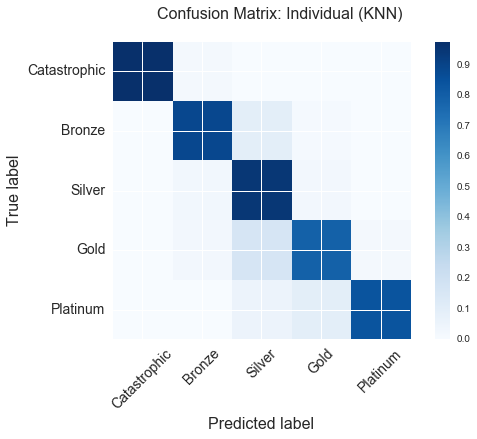

In [137]:
plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Confusion Matrix: Individual (KNN)\n',
                      labels=labels)

## To summarize, the best model obtained for  binary classification was the SGD model with an accuracy of 100%.  The best model obtained for Multi-Class classification was the RandomForest model with an accuracy of 96%.
## Insurance companies may want to use these models to gain some insight into how their plans are perceived by customers. Customers often rely on Metal Levels to make decisions about plans and it could prove profitable to offer customers more insight into the main components that make up the plan and how it contributes to the Metal Level. One way to test this is to setup an A/B test where customer have more information based on these models while another group of customers do not. 